# Valores missing, outlier y correlaciones

En este notebook se lleva a cabo el análisis y preprocesamiento de variables numéricas y categóricas con un enfoque estructurado.

El proceso comienza con la revisión y ajuste de los tipos de datos, asegurando que cada variable tenga el formato adecuado según su naturaleza. A continuación, el conjunto de datos se divide en dos subconjuntos, train y test, para facilitar una evaluación adecuada en las etapas posteriores de modelado.

Para las variables numéricas, se realiza un análisis descriptivo detallado, apoyado en gráficos que permiten explorar su distribución y características clave. Se examinan las correlaciones utilizando los coeficientes de Pearson y Spearman, se identifican y gestionan los outliers y se abordan los valores faltantes con estrategias adecuadas según el contexto.

En cuanto a las variables categóricas, el tratamiento incluye la imputación de valores faltantes y el análisis de correlaciones mediante el coeficiente V de Cramer, el Weight of Evidence (WOE) y el Information Value (IV). Estos enfoques permiten comprender las relaciones entre las variables categóricas y otras presentes en el conjunto de datos.

## Importo librerias 

Para comenzar, se importan las librerías necesarias en este notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
import scipy.stats as ss
import warnings
from plotnine import ggplot, aes, geom_bar, labs

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

## Lectura de datos del procesado inicial

Es importante señalar que, en este segundo notebook, trabajaremos con los datos originales tal como aparecen en el notebook anterior, ya que no he realizado ninguna modificación. Además, se establece la columna `SK_ID_CURR` como índice del DataFrame para facilitar su manipulación y análisis.

In [2]:
path_folder = "../data/raw/application_data.csv"
pd_loan = pd.read_csv(path_folder).set_index("SK_ID_CURR") 

Recordamos las dimensiones y los tipos de datos con los que estamos trabajando: 

In [3]:
pd_loan.shape

(307511, 121)

In [4]:
pd_loan.columns

Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=121)

In [5]:
pd_loan.dtypes.sort_values().to_frame('feature_type').groupby(by = 'feature_type').size().to_frame('count').reset_index()

feature_type  count
0        int64     40
1      float64     65
2       object     16


Se identifican y clasifican las variables del conjunto de datos en categóricas y continuas, asegurando que cada una tenga el tipo de dato adecuado según su naturaleza. Después, se ajustan los tipos de datos para garantizar su correcta interpretación y manipulación en las etapas posteriores del análisis

In [6]:
def dame_variables_categoricas(dataset=None):
    '''
    ----------------------------------------------------------------------------------------------------------
    Función dame_variables_categoricas:
    ----------------------------------------------------------------------------------------------------------
    - Descripción:
        Esta función recibe un DataFrame y devuelve una lista de las variables categóricas 
        (con pocos valores únicos).
        
    - Inputs: 
        - dataset (DataFrame): DataFrame que contiene los datos de entrada.
        
    - Return:
        - lista_variables_categoricas (list): Lista con los nombres de las variables 
          categóricas en el DataFrame.
        - other (list): Lista con los nombres de las variables que no cumplen los criterios 
          para ser categóricas.
        - 1: Indica que la ejecución es incorrecta debido a la falta del 
          argumento 'dataset'.
    '''
    # Verificar que el DataFrame de entrada no sea nulo
    if dataset is None:
        print(u'\nError: Falta el argumento dataset en la función')
        return 1 
    
    lista_variables_categoricas = []  
    other = []  

    # Recorrer las columnas del DataFrame
    for i in dataset.columns:
        
        # Si la columna es de tipo objeto (posiblemente categórica)
        if dataset[i].dtype == object:
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                lista_variables_categoricas.append(i)  
            else:
                other.append(i)  
                
        # Si la columna es de tipo entero                
        if dataset[i].dtype == int:
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 20:
                lista_variables_categoricas.append(i)  
            else:
                other.append(i) 

    return lista_variables_categoricas, other

In [7]:
# Identificar las variables categóricas
list_var_cat, other = dame_variables_categoricas(dataset=pd_loan)
pd_loan[list_var_cat] = pd_loan[list_var_cat].astype("category")

# Seleccionar las columnas que contienen datos numéricos continuos
list_var_continuous = list(pd_loan.select_dtypes(['float', 'int']).columns)
pd_loan[list_var_continuous] = pd_loan[list_var_continuous].astype(float)

Es importante destacar que algunas variables clasificadas inicialmente como enteras son, en realidad, de naturaleza booleana, lo que las convierte en categóricas. Por otro lado, existen variables enteras que corresponden a valores continuos. Por esta razón, lo más seguro es que las variables almacenadas en `other` representan aquellas que, aunque son enteras, se consideran verdaderamente continuas.

In [8]:
other

['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START']

Es interesante destacar que las variables que representan diferencias de tiempo incluyen valores tanto negativos como positivos, ya que están definidas en relación al momento de la solicitud del crédito. Esto implica que reflejan eventos ocurridos antes o después de dicha solicitud. Más adelante, se estudiarán con mayor detenimiento

In [9]:
pd_loan.dtypes

TARGET                          category
NAME_CONTRACT_TYPE              category
CODE_GENDER                     category
FLAG_OWN_CAR                    category
FLAG_OWN_REALTY                 category
CNT_CHILDREN                    category
AMT_INCOME_TOTAL                 float64
AMT_CREDIT                       float64
AMT_ANNUITY                      float64
AMT_GOODS_PRICE                  float64
NAME_TYPE_SUITE                 category
NAME_INCOME_TYPE                category
NAME_EDUCATION_TYPE             category
NAME_FAMILY_STATUS              category
NAME_HOUSING_TYPE               category
REGION_POPULATION_RELATIVE       float64
DAYS_BIRTH                       float64
DAYS_EMPLOYED                    float64
DAYS_REGISTRATION                float64
DAYS_ID_PUBLISH                  float64
OWN_CAR_AGE                      float64
FLAG_MOBIL                      category
FLAG_EMP_PHONE                  category
FLAG_WORK_PHONE                 category
FLAG_CONT_MOBILE

## Separación en train y test estratificado

Antes de entrenar el modelo, realizamos una separación estratificada de los datos en conjuntos de entrenamiento y prueba, para asegurar que la distribución de las clases en la variable `TARGET` se mantenga proporcional.

In [10]:
pd_plot_target = pd_loan['TARGET']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()

pd_plot_target_conteo = pd_loan['TARGET'].value_counts().reset_index()
pd_plot_target_pc = pd.merge(pd_plot_target, 
                                  pd_plot_target_conteo, on=['TARGET'], how='inner')

In [11]:
pd_plot_target_pc['TARGET'] = pd_plot_target_pc['TARGET'].astype(str)
gg = (
    ggplot(pd_plot_target_pc, aes(x='TARGET', y='percent', weight='percent'))  
    + geom_bar(stat='identity')  
    + labs(x='Variable objetivo', y='Porcentaje', title='Distribución porcentual de la variable objetivo')  
)

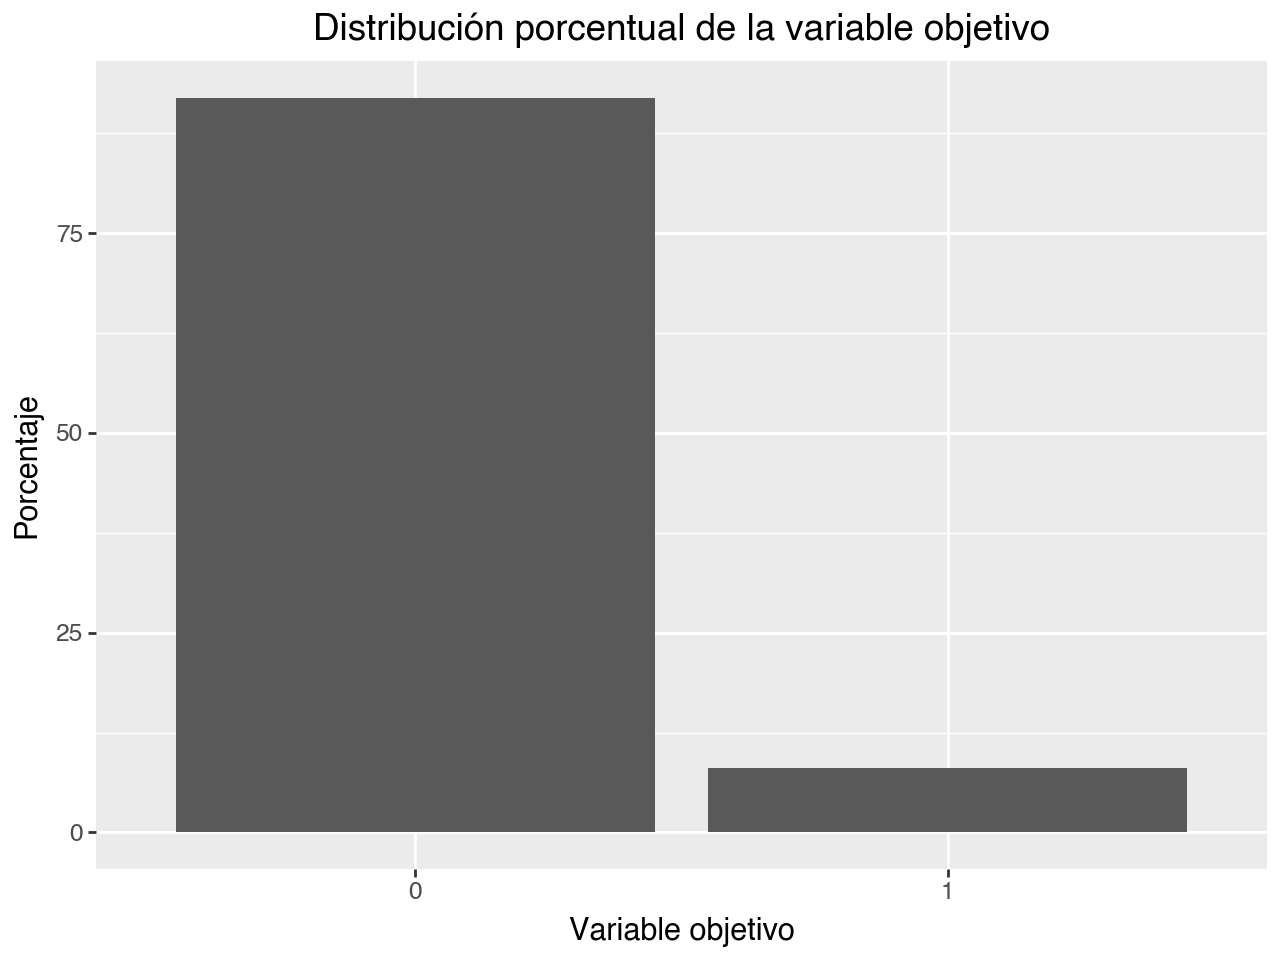

In [12]:
gg


Como hemos comentado en notebook anterior, se puede observar que el muestreo está desbalanceado, ya que la mayoría de los clientes no tienen dificultades para pagar el préstamo

El 20% de los datos se asignan al conjunto de prueba y el 80% al conjunto de entrenamiento para entrenar el modelo con la mayoría de los datos y evaluar su desempeño con una muestra representativa y no utilizada en el entrenamiento.

In [13]:
from sklearn.model_selection import train_test_split
X_pd_loan, X_pd_loan_test, y_pd_loan, y_pd_loan_test = train_test_split(pd_loan.drop('TARGET',axis=1), 
                                                                     pd_loan['TARGET'], 
                                                                     stratify=pd_loan['TARGET'], 
                                                                     test_size=0.2)
pd_loan_train = pd.concat([X_pd_loan, y_pd_loan],axis=1)
pd_loan_test = pd.concat([X_pd_loan_test, y_pd_loan_test],axis=1)

In [14]:
print('== Train\n', pd_loan_train['TARGET'].value_counts(normalize=True))
print('== Test\n', pd_loan_test['TARGET'].value_counts(normalize=True))

== Train
 TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64
== Test
 TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64



La salida muestra que tanto en el conjunto de entrenamiento como en el de prueba, las proporciones de ambas clases son prácticamente idénticas, lo que confirma que la separación estratificada ha mantenido el balance de las clases en ambos conjuntos

## Visualización descriptiva de los datos


Este análisis muestra la cantidad de valores nulos por filas y por columnas en el conjunto de entrenamiento, ayudando a identificar qué variables o registros contienen datos faltantes.

In [15]:
pd_series_null_columns = pd_loan_train.isnull().sum().sort_values(ascending=False)
pd_series_null_rows = pd_loan_train.isnull().sum(axis=1).sort_values(ascending=False)
print(pd_series_null_columns.shape, pd_series_null_rows.shape)

pd_null_columnas = pd.DataFrame(pd_series_null_columns, columns=['nulos_columnas'])     
pd_null_filas = pd.DataFrame(pd_series_null_rows, columns=['nulos_filas'])  
pd_null_filas['target'] = pd_loan['TARGET'].copy()
pd_null_columnas['porcentaje_columnas'] = pd_null_columnas['nulos_columnas']/pd_loan_train.shape[0]
pd_null_filas['porcentaje_filas']= pd_null_filas['nulos_filas']/pd_loan_train.shape[1]

(121,) (246008,)


In [16]:
pd_null_columnas

nulos_columnas  porcentaje_columnas
COMMONAREA_MODE                       171834             0.698489
COMMONAREA_MEDI                       171834             0.698489
COMMONAREA_AVG                        171834             0.698489
NONLIVINGAPARTMENTS_MEDI              170734             0.694018
NONLIVINGAPARTMENTS_MODE              170734             0.694018
NONLIVINGAPARTMENTS_AVG               170734             0.694018
FONDKAPREMONT_MODE                    168204             0.683734
LIVINGAPARTMENTS_AVG                  168114             0.683368
LIVINGAPARTMENTS_MEDI                 168114             0.683368
LIVINGAPARTMENTS_MODE                 168114             0.683368
FLOORSMIN_MODE                        166875             0.678332
FLOORSMIN_MEDI                        166875             0.678332
FLOORSMIN_AVG                         166875             0.678332
YEARS_BUILD_AVG                       163539             0.664771
YEARS_BUILD_MEDI                      163539             0.664771
YEARS_BUILD_MODE                      163539             0.664771
OWN_CAR_AGE                           162531             0.660674
LANDAREA_MEDI                         146103             0.593895
LANDAREA_AVG                          146103             0.593895
LANDAREA_MODE                         146103             0.593895
BASEMENTAREA_MEDI                     144013             0.585400
BASEMENTAREA_MODE                     144013             0.585400
BASEMENTAREA_AVG                      144013             0.585400
EXT_SOURCE_1                          138726             0.563908
NONLIVINGAREA_AVG                     135800             0.552015
NONLIVINGAREA_MEDI                    135800             0.552015
NONLIVINGAREA_MODE                    135800             0.552015
ELEVATORS_AVG                         131208             0.533349
ELEVATORS_MEDI                        131208             0.533349
ELEVATORS_MODE                        131208             0.533349
WALLSMATERIAL_MODE                    125183             0.508857
APARTMENTS_AVG                        124962             0.507959
APARTMENTS_MODE                       124962             0.507959
APARTMENTS_MEDI                       124962             0.507959
ENTRANCES_MODE                        124014             0.504106
ENTRANCES_AVG                         124014             0.504106
ENTRANCES_MEDI                        124014             0.504106
LIVINGAREA_MODE                       123568             0.502293
LIVINGAREA_AVG                        123568             0.502293
LIVINGAREA_MEDI                       123568             0.502293
HOUSETYPE_MODE                        123529             0.502134
FLOORSMAX_MEDI                        122539             0.498110
FLOORSMAX_AVG                         122539             0.498110
FLOORSMAX_MODE                        122539             0.498110
YEARS_BEGINEXPLUATATION_MEDI          120100             0.488196
YEARS_BEGINEXPLUATATION_MODE          120100             0.488196
YEARS_BEGINEXPLUATATION_AVG           120100             0.488196
TOTALAREA_MODE                        118840             0.483074
EMERGENCYSTATE_MODE                   116698             0.474367
OCCUPATION_TYPE                        77285             0.314156
EXT_SOURCE_3                           48805             0.198388
AMT_REQ_CREDIT_BUREAU_MON              33288             0.135313
AMT_REQ_CREDIT_BUREAU_HOUR             33288             0.135313
AMT_REQ_CREDIT_BUREAU_YEAR             33288             0.135313
AMT_REQ_CREDIT_BUREAU_QRT              33288             0.135313
AMT_REQ_CREDIT_BUREAU_DAY              33288             0.135313
AMT_REQ_CREDIT_BUREAU_WEEK             33288             0.135313
NAME_TYPE_SUITE                         1042             0.004236
OBS_30_CNT_SOCIAL_CIRCLE                 810             0.003293
DEF_30_CNT_SOCIAL_CIRCLE                 810             0.003293
OBS_

In [17]:
pd_null_filas.head()

nulos_filas target  porcentaje_filas
SK_ID_CURR                                      
235599               61      0          0.504132
412671               61      0          0.504132
180861               61      0          0.504132
315294               61      0          0.504132
383369               61      0          0.504132

No se ha eliminado ninguna columna en este análisis, ya que no se ha identificado un porcentaje de valores nulos lo suficientemente alto como para justificarlo. Aunque en general es importante eliminar columnas con un exceso de nulos para evitar pérdida de información importante, en este caso todas las columnas se han conservado, considerando que incluso aquellas con valores faltantes podrían seguir siendo relevantes.

A continuación, visualizamos la distribución de las demás variables en el conjunto de datos, tanto de manera general como en función de la variable objetivo `TARGET`. Esto nos permitirá entender mejor cómo se distribuyen las variables y cómo podrían estar relacionadas con la presencia de dificultades de pago en los clientes (1: dificultades de pago, 0: sin dificultades de pago).

In [21]:
def plot_feature(df, col_name, isContinuous):
    '''
    ----------------------------------------------------------------------------------------------------------
    Función plot_feature:
    ----------------------------------------------------------------------------------------------------------
    - Descripción:
        Esta función visualiza una variable, mostrando su distribución general y su
        relación con el estado la variable objetivo (TARGET). Para variables continuas,
        se usa un histograma y un boxplot; para variables categóricas, se usa un gráfico 
        de barras y uno de barras apiladas.
        
    - Inputs: 
        - df (DataFrame): DataFrame que contiene los datos de entrada.
        - col_name (str): Nombre de la variable a visualizar.
        - isContinuous (bool): Indica si la variable es continua (True) 
          o categórica (False).
        
    - Return:
         - None: Muestra los gráficos sin devolver valores.
    '''
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    count_null = df[col_name].isnull().sum()
    
    # Gráfico sin considerar la variable objetivo
    if isContinuous:
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, color='#5975A4', ax=ax1)
    else:
        order = df[col_name].dropna().value_counts().index
        sns.countplot(df[col_name].dropna(), order=order, color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name)
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)

    # Gráfico considerando la variable objetivo
    if isContinuous:
        sns.boxplot(x=col_name, y='TARGET', data=df, ax=ax2, palette='Set2') 
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by Target')
    else:
        data = df.groupby(col_name)["TARGET"].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [col_name, "TARGET", 'proportion']
        #sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        sns.barplot(x = col_name, y = 'proportion', hue= "TARGET", order=order, data = data, saturation=1, ax=ax2, palette='Set2')
        ax2.set_ylabel("TARGET"+' fraction')
        ax2.set_title("TARGET")
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()
    plt.show()

Para facilitar la interpretación y comprensión de los gráficos, primero se graficarán las variables continuas y, a continuación, las variables categóricas.

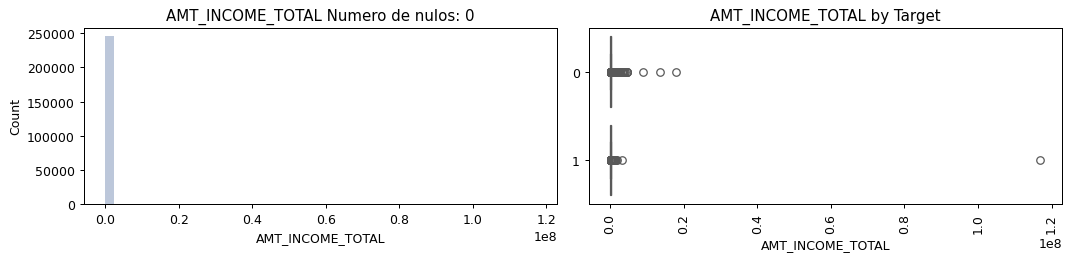

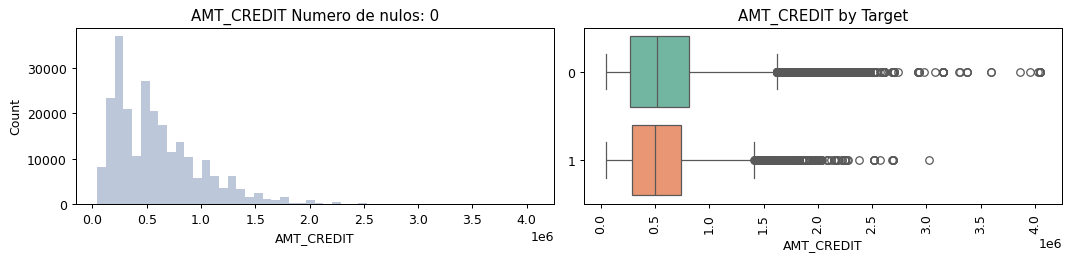

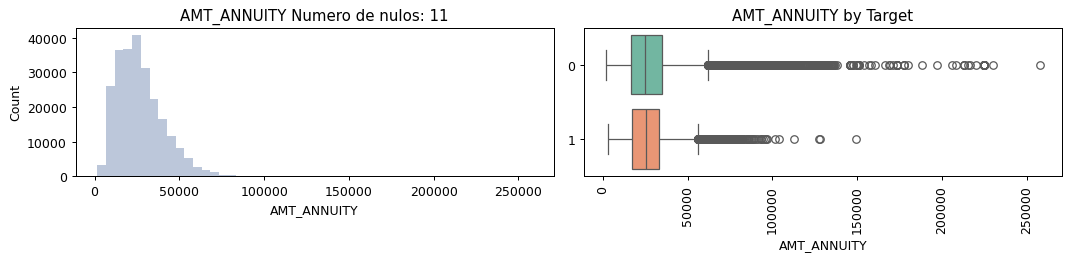

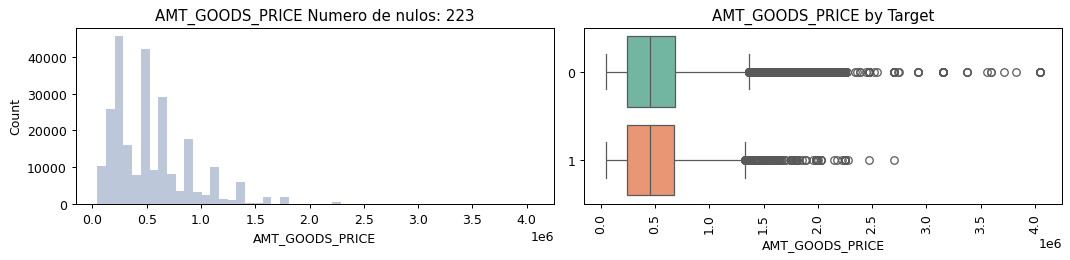

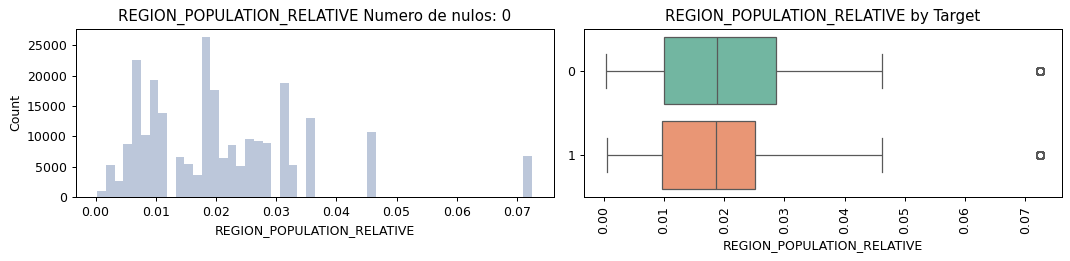

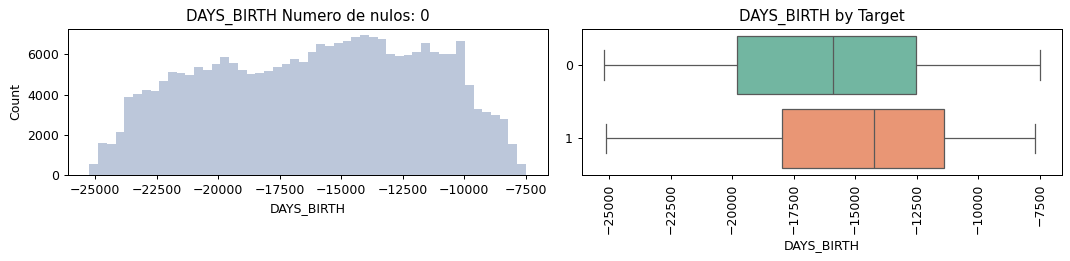

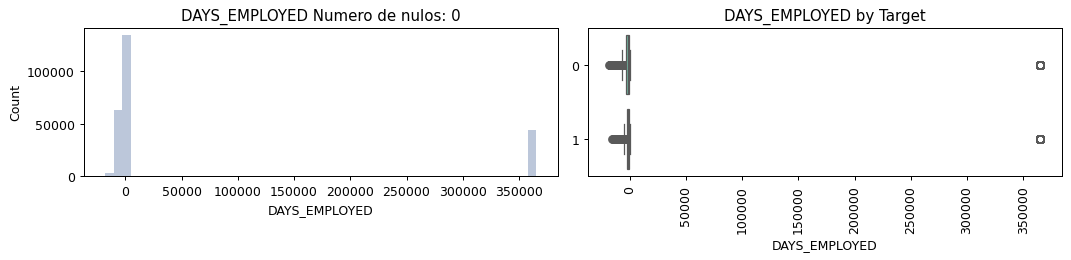

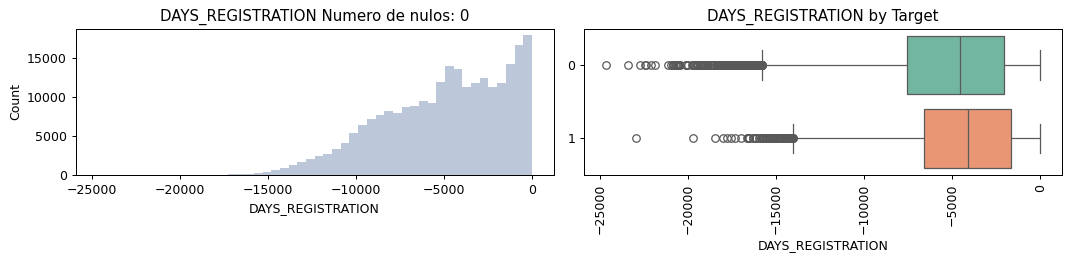

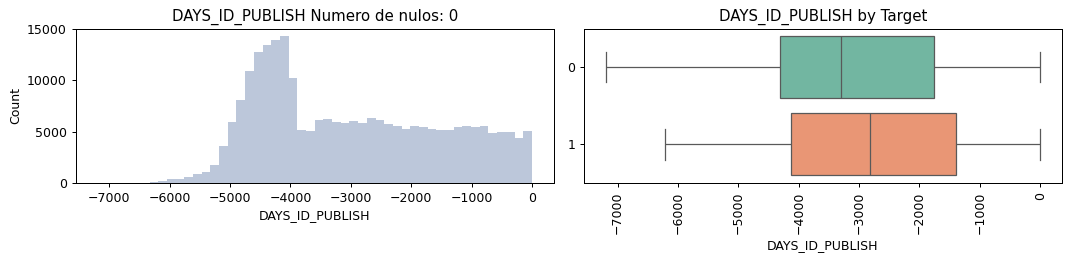

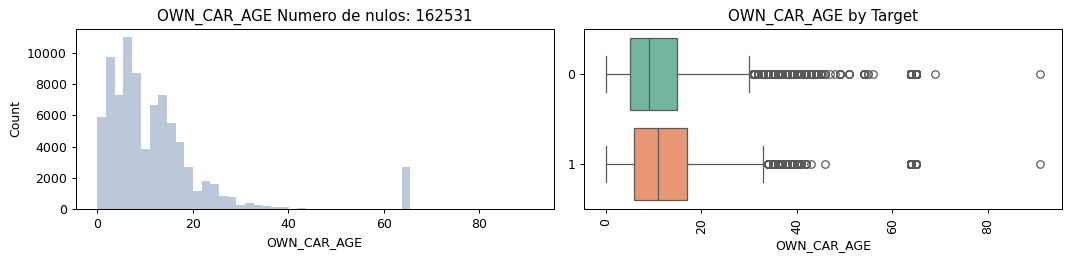

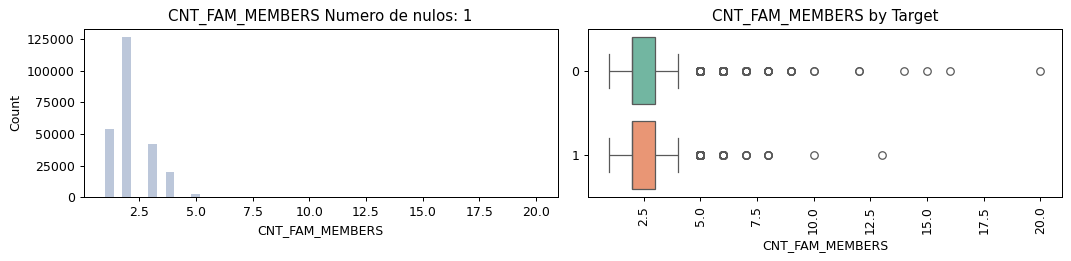

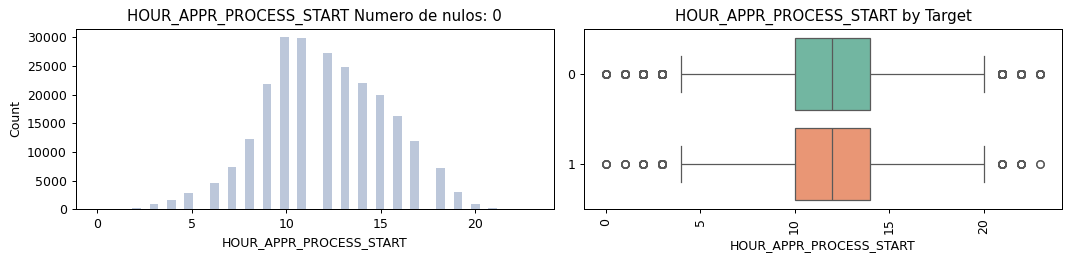

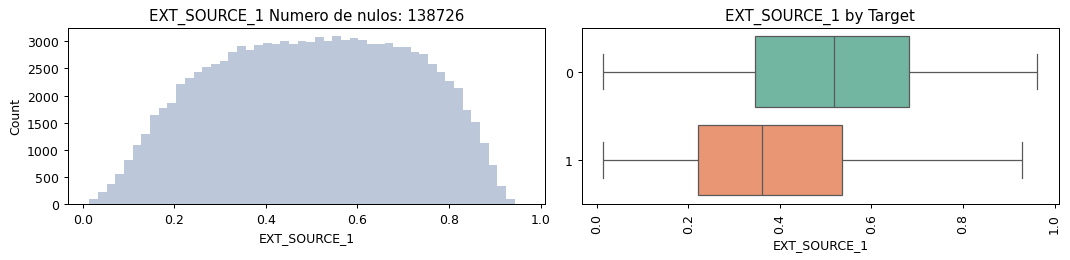

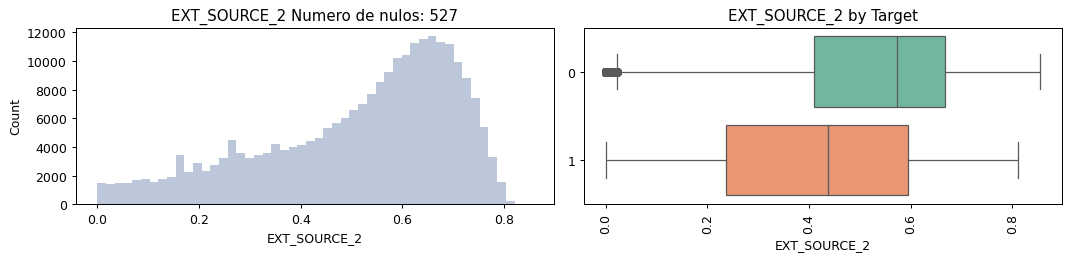

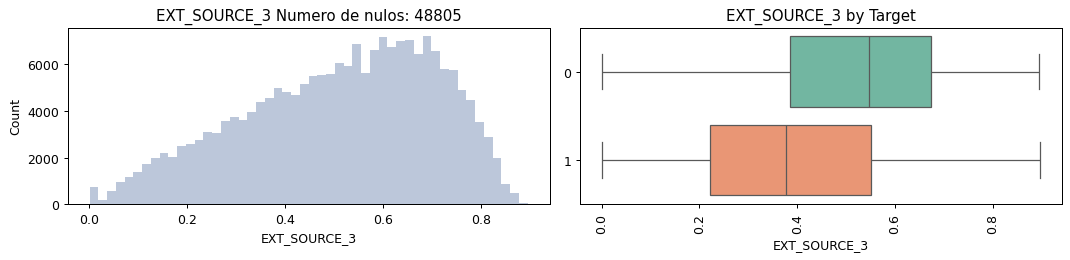

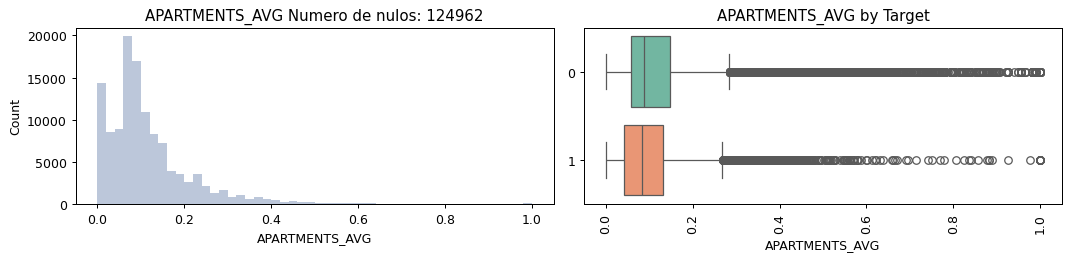

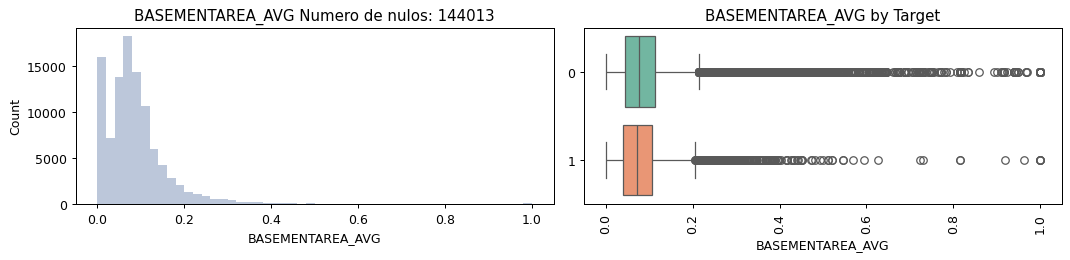

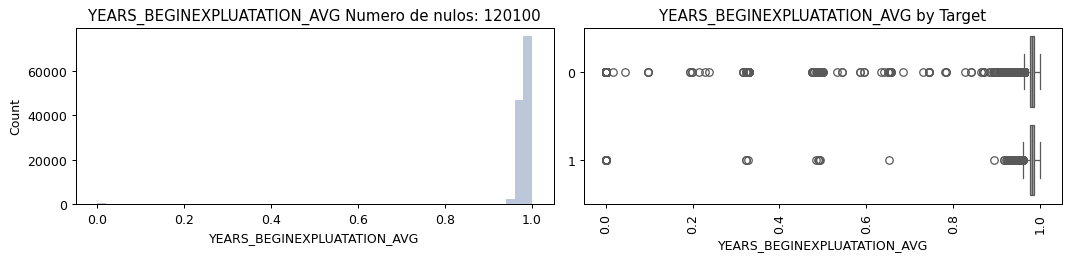

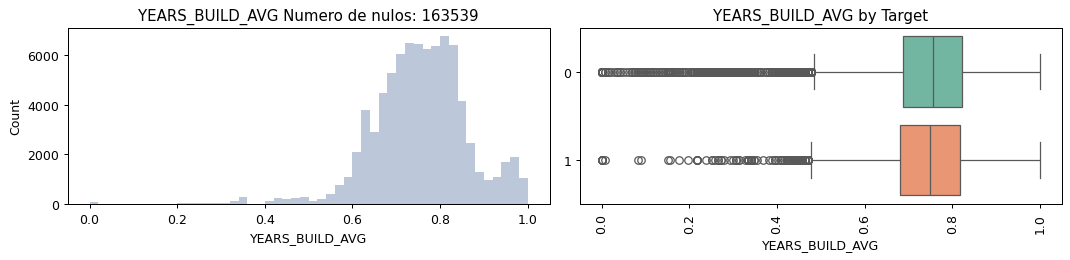

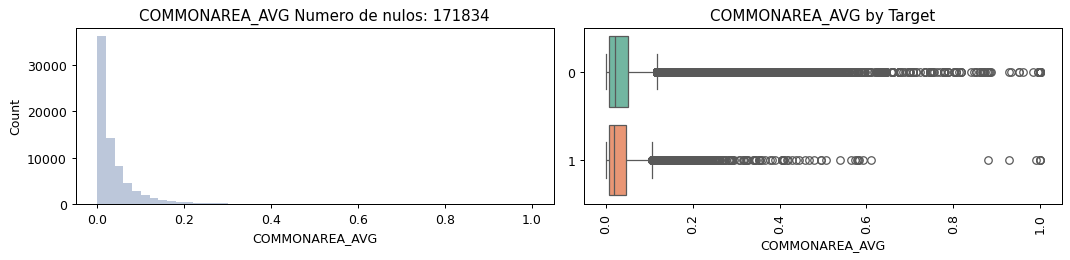

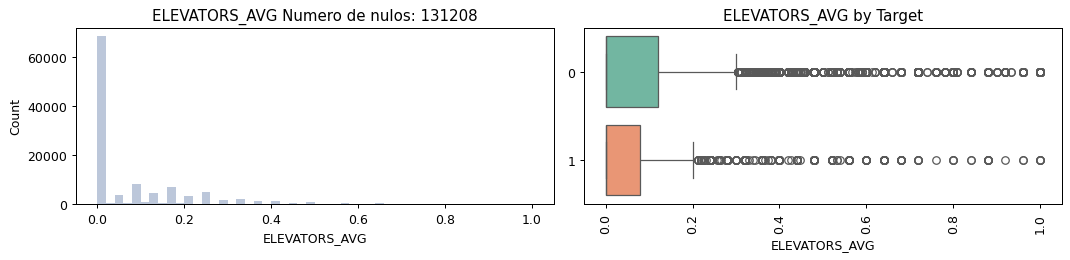

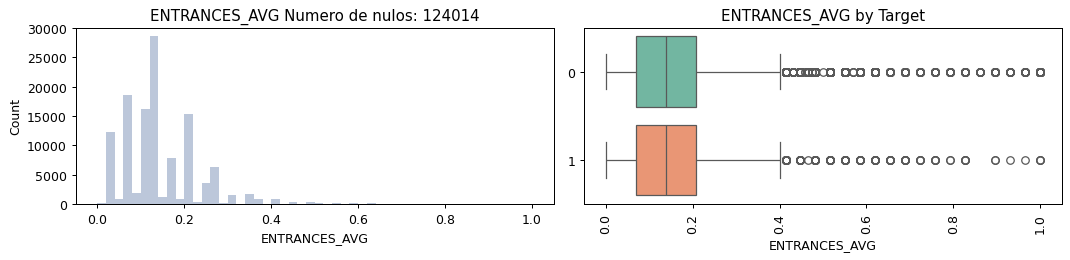

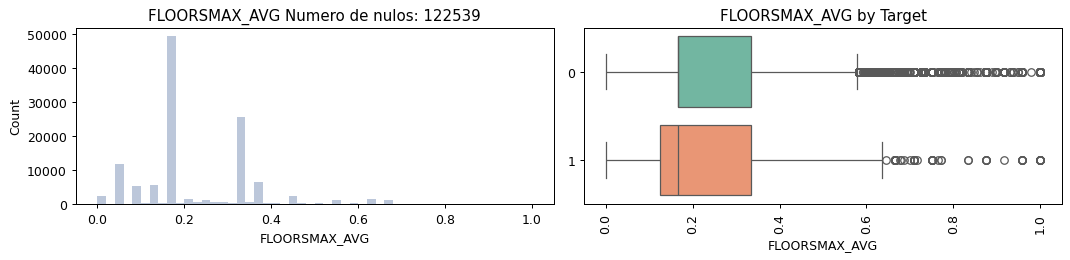

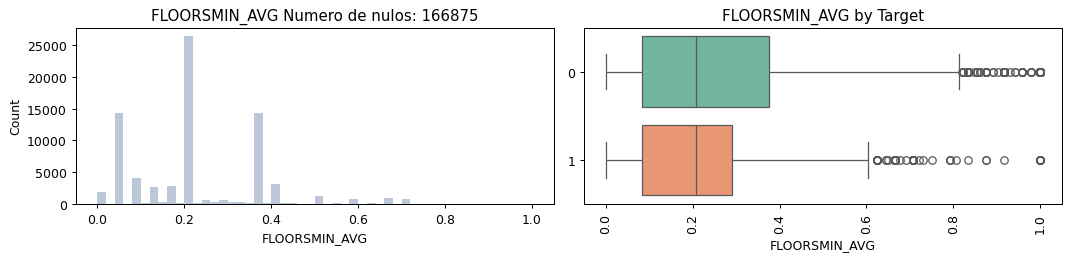

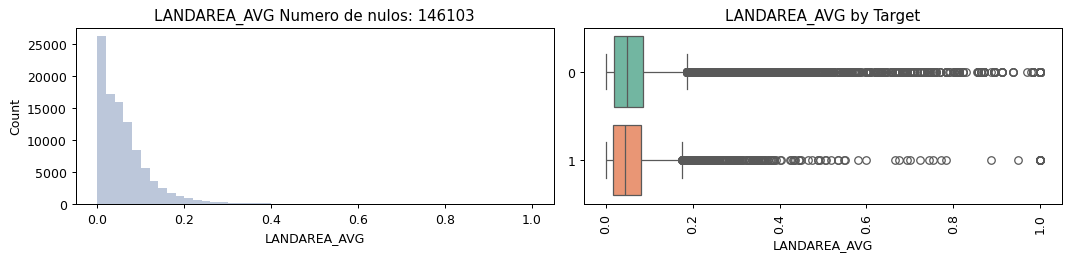

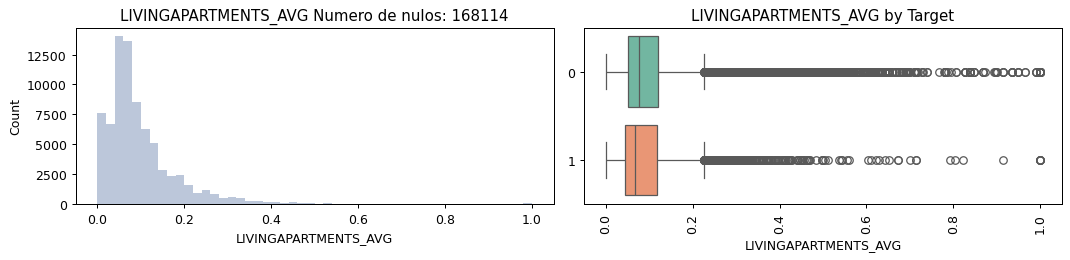

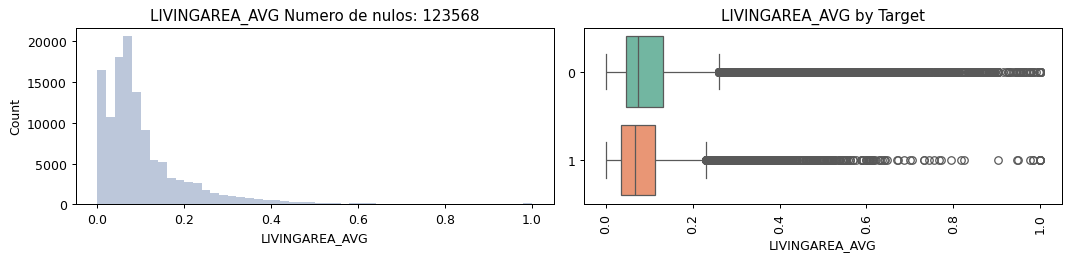

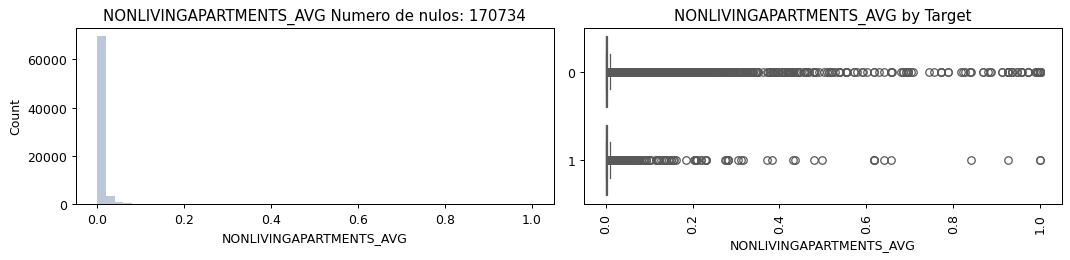

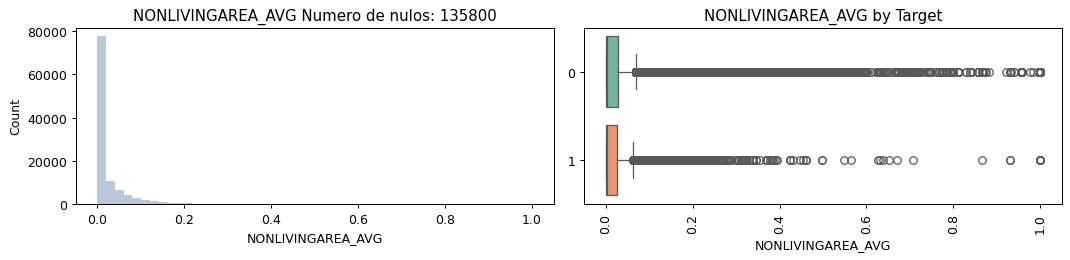

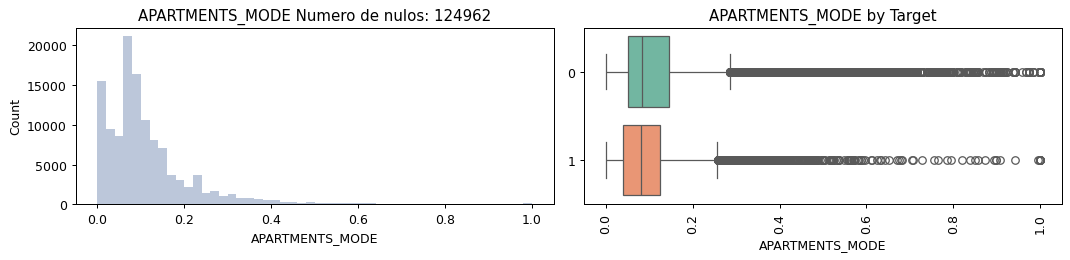

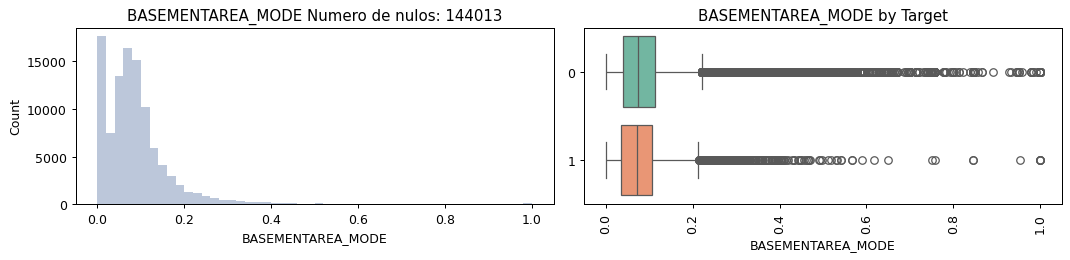

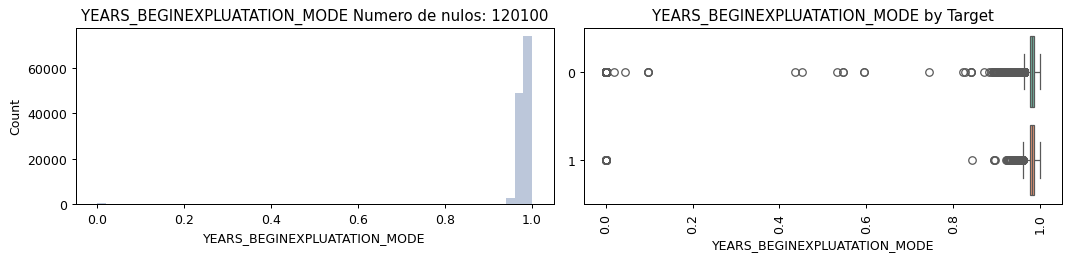

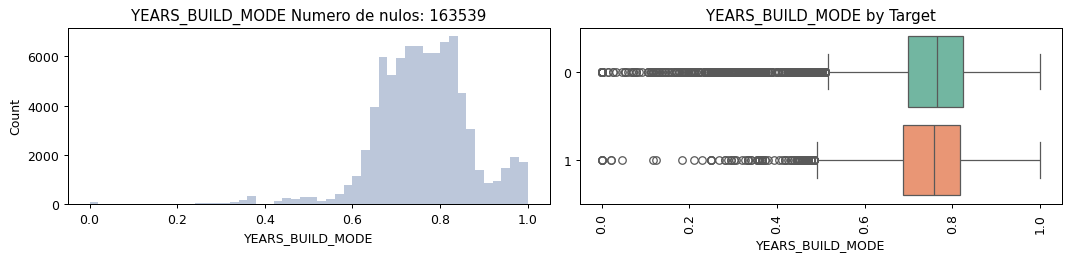

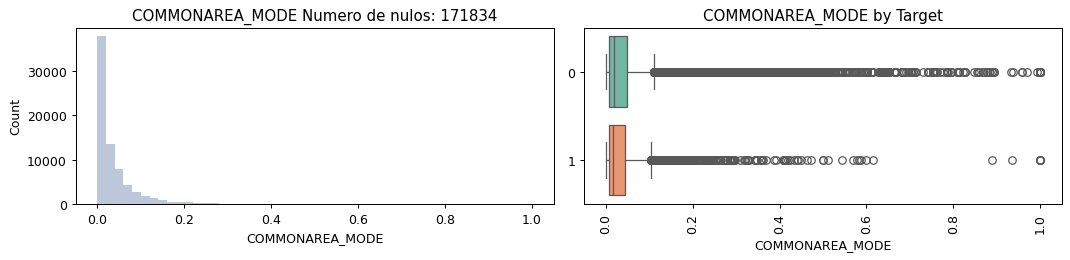

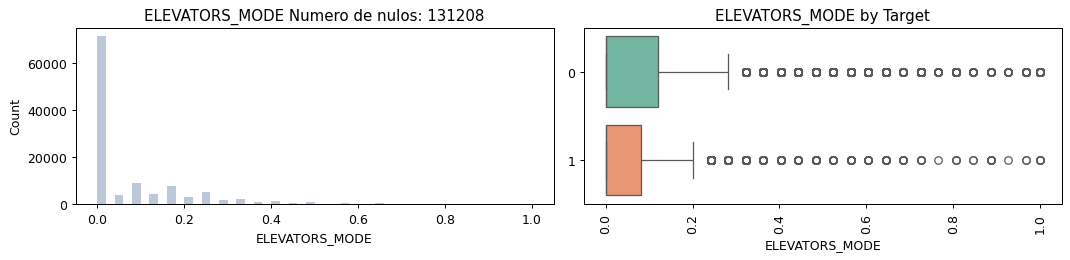

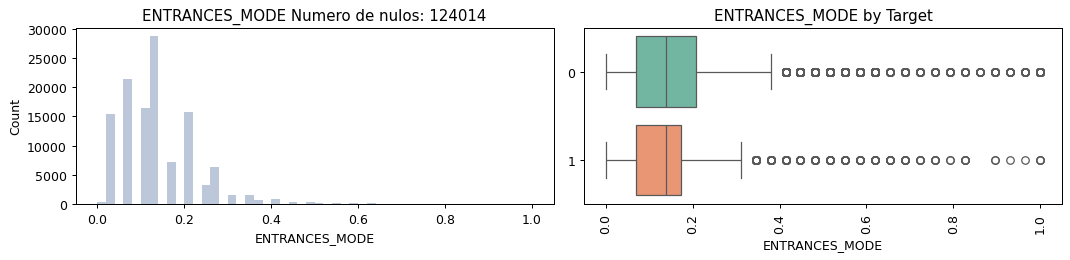

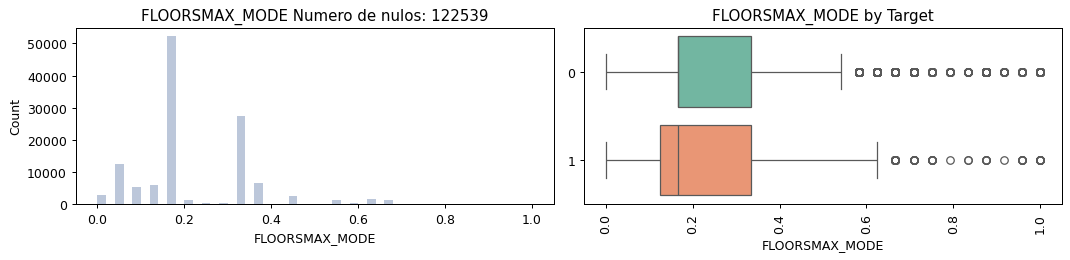

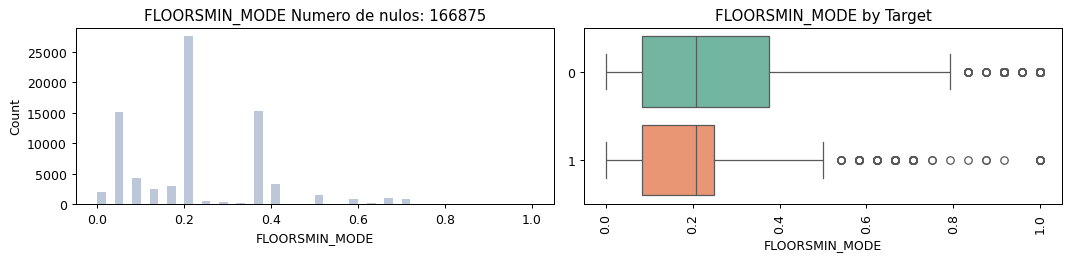

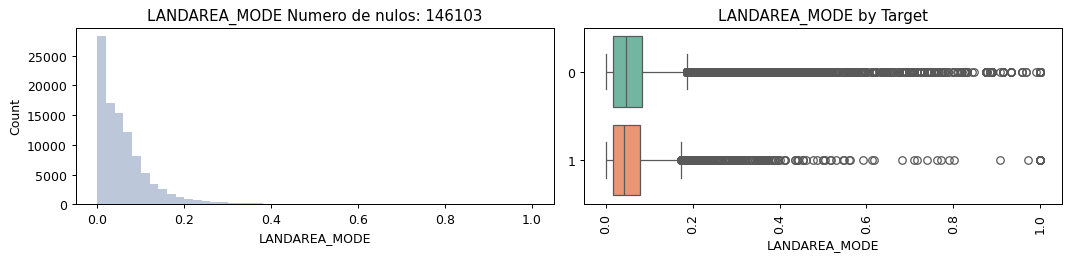

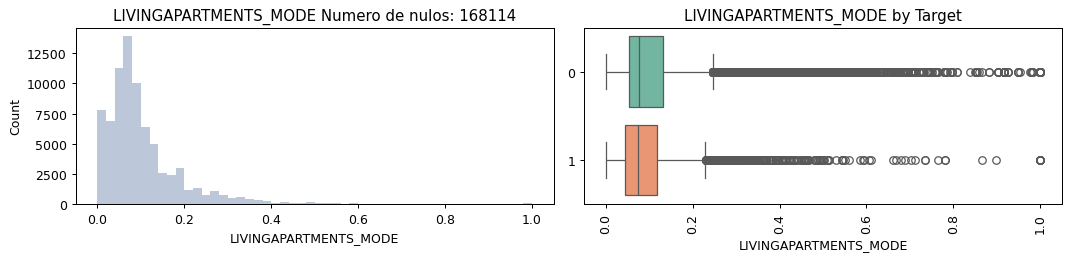

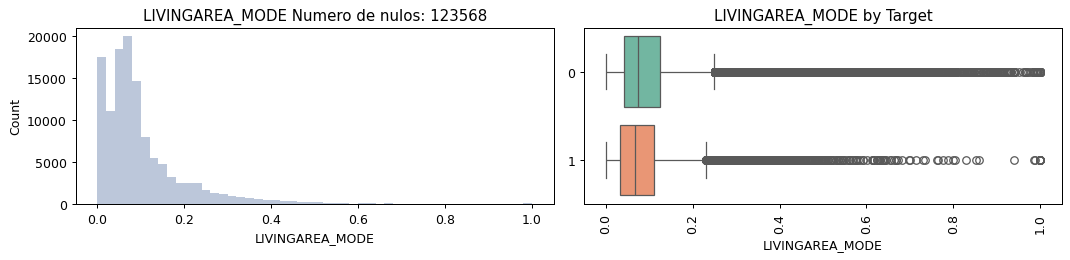

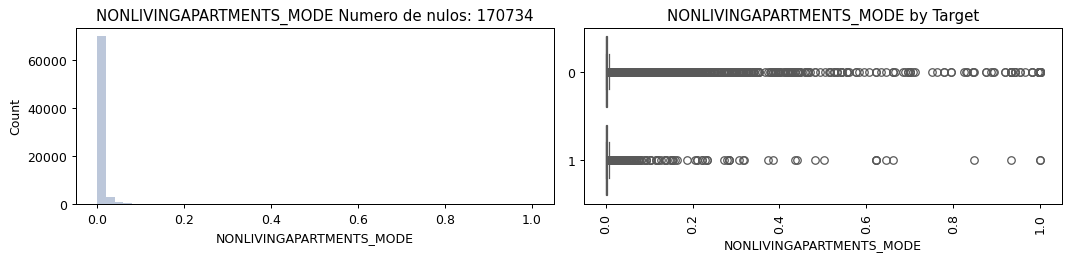

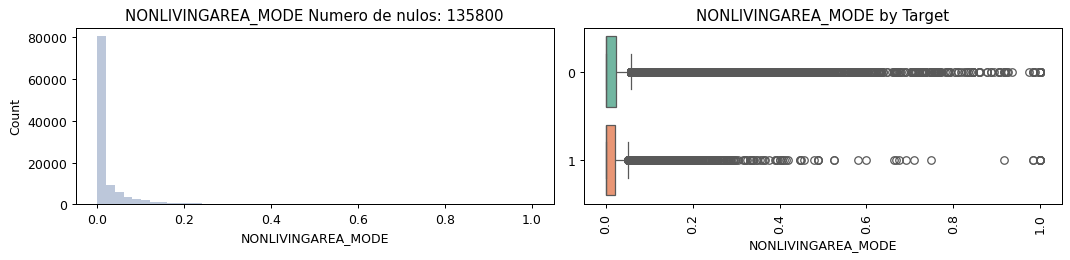

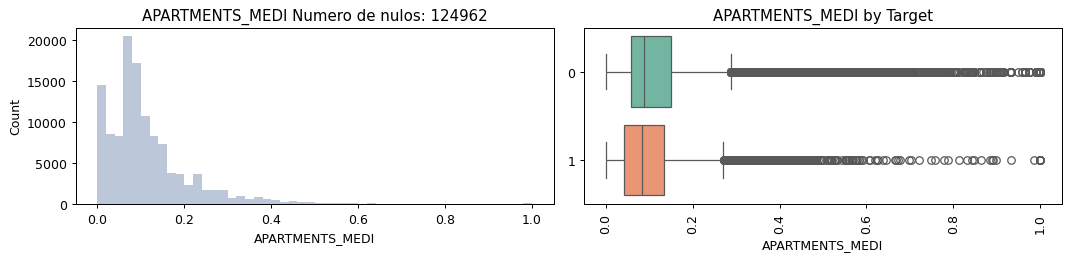

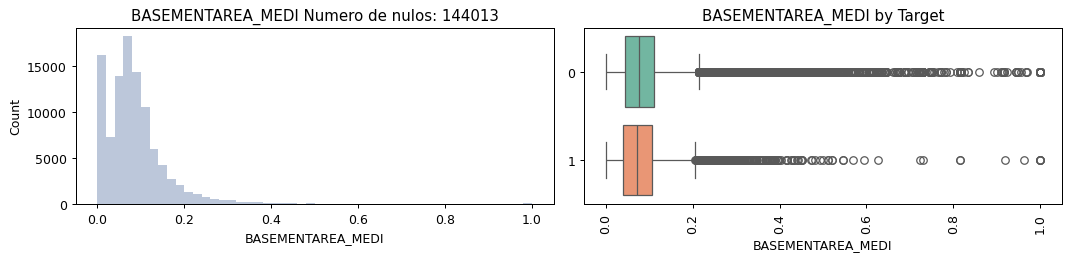

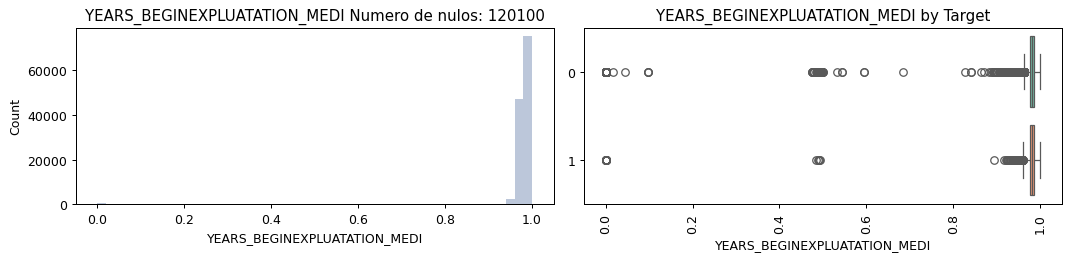

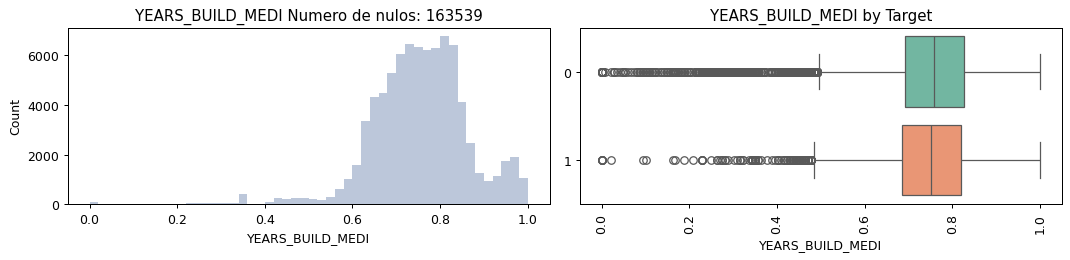

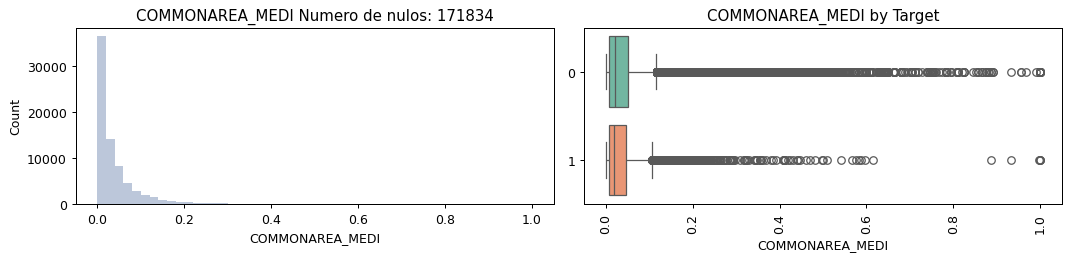

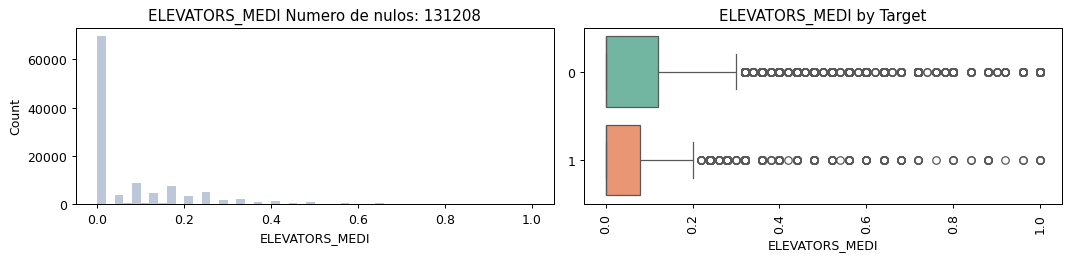

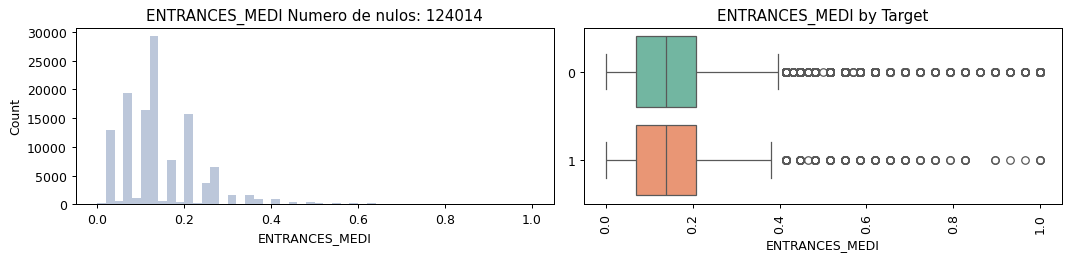

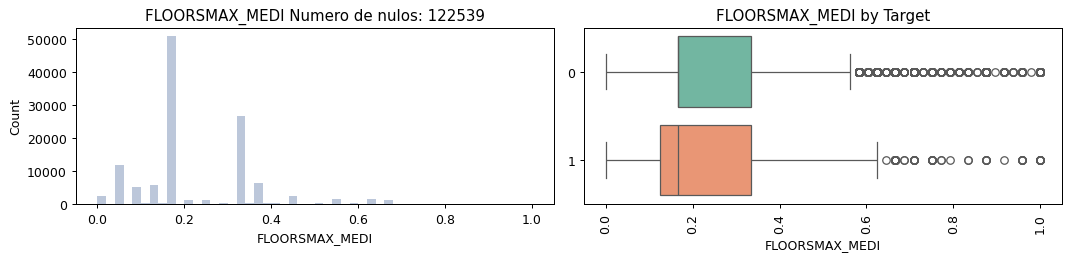

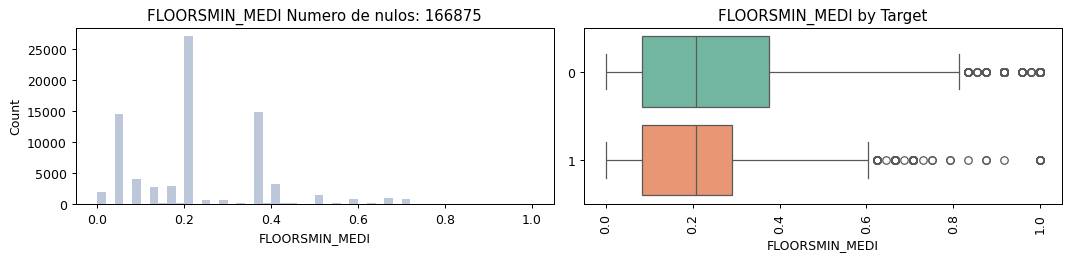

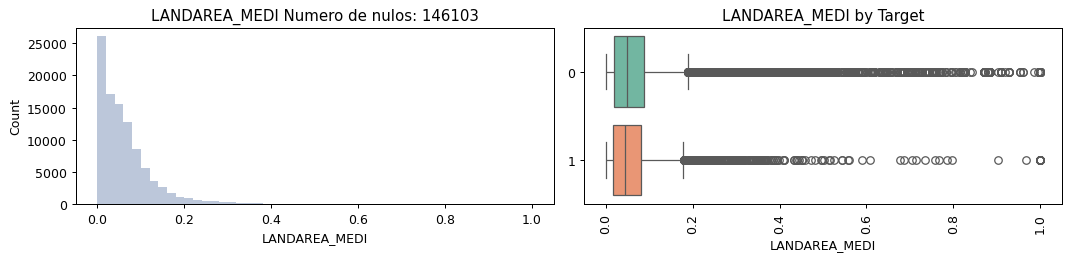

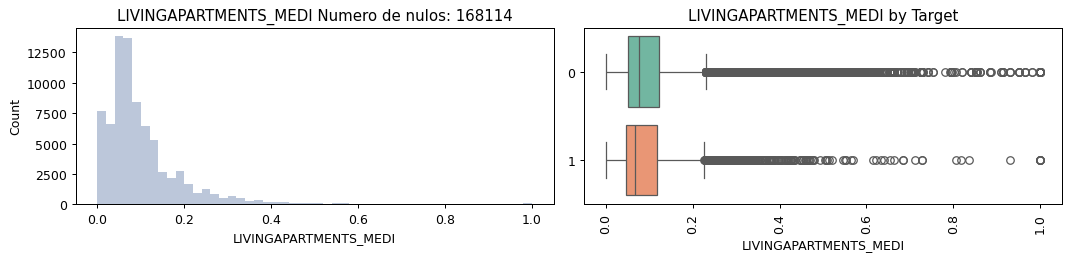

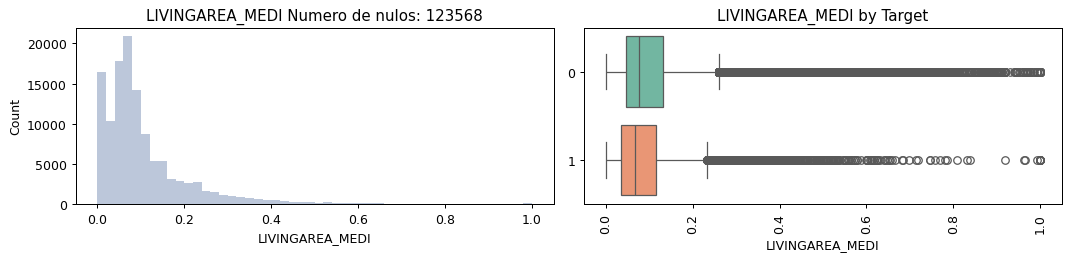

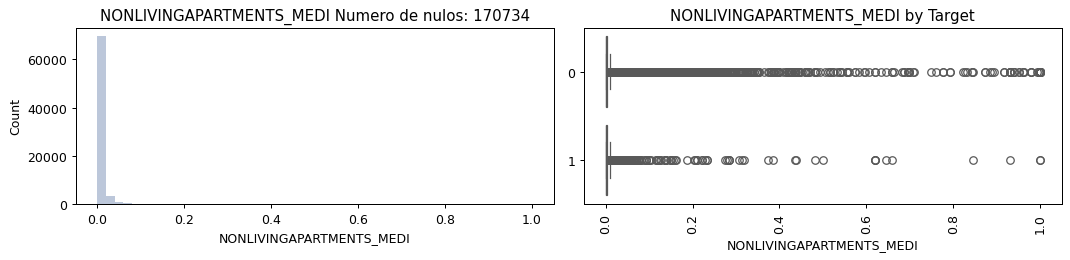

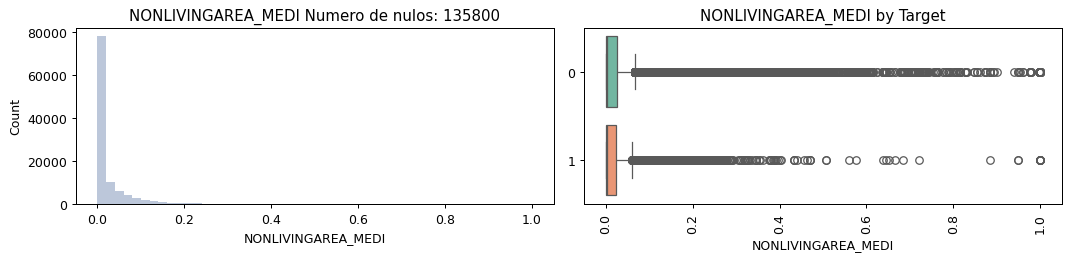

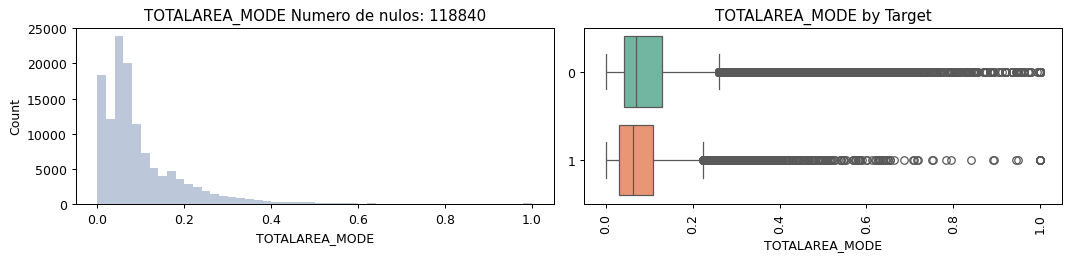

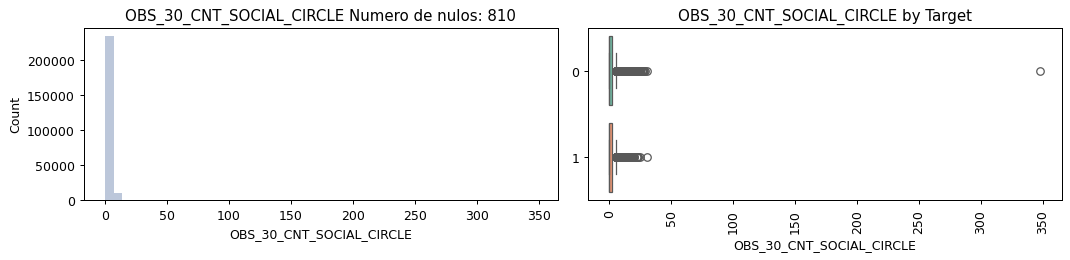

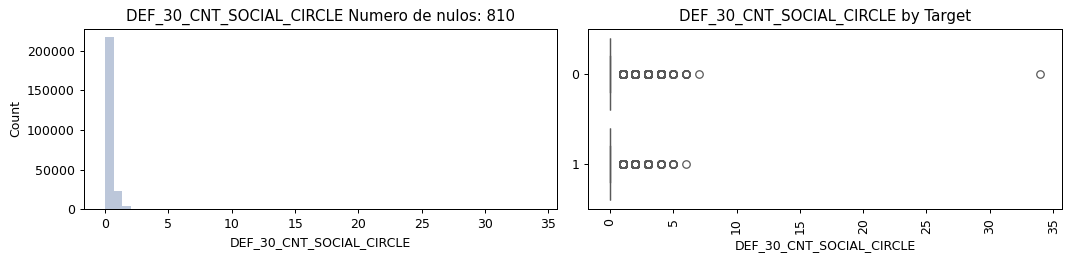

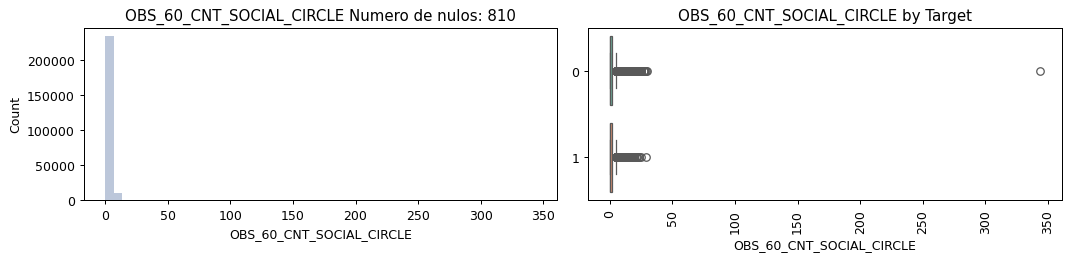

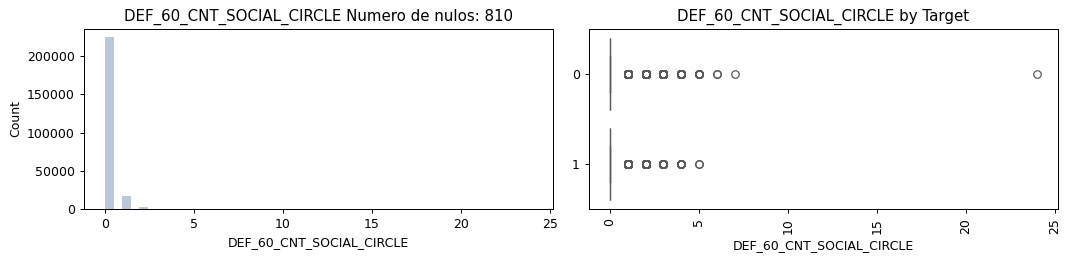

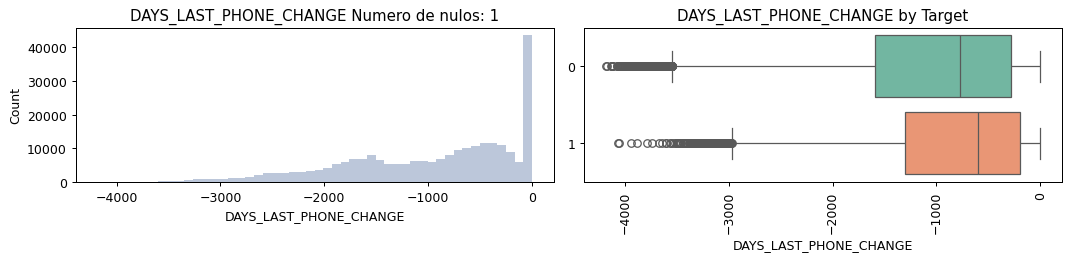

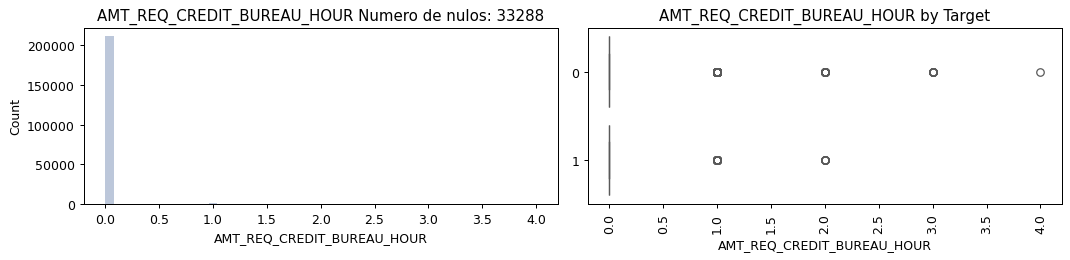

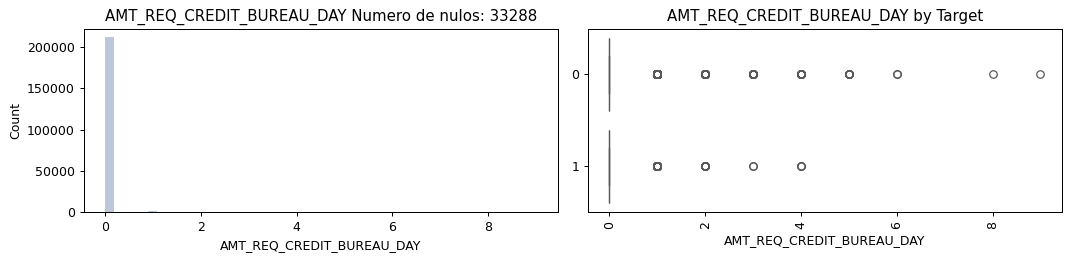

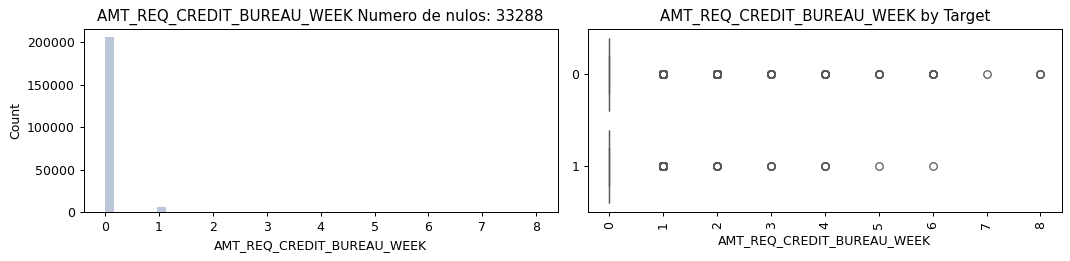

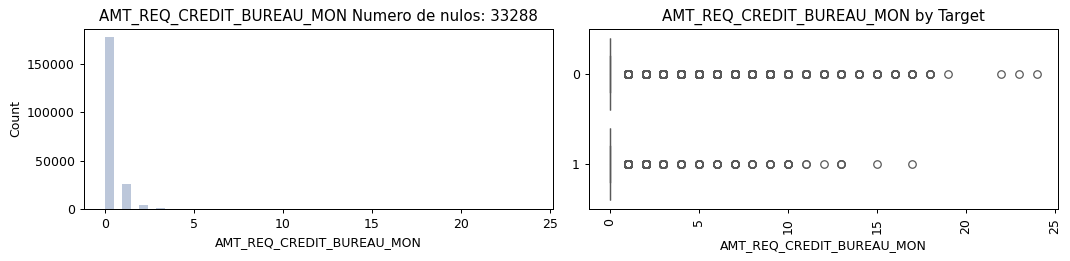

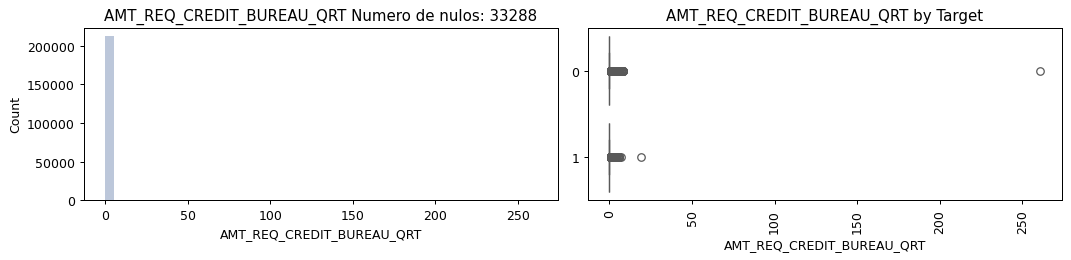

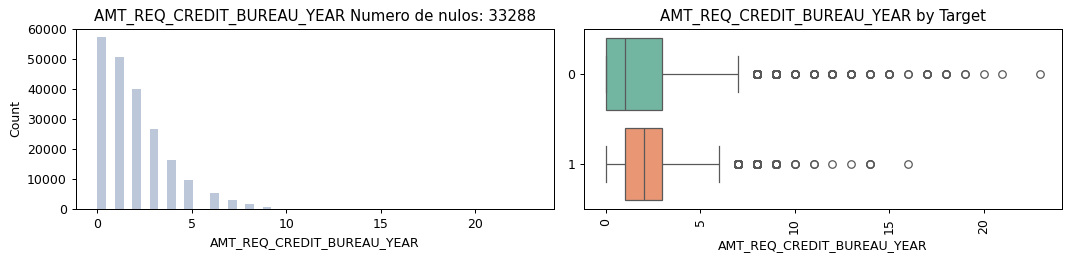

In [19]:
warnings.filterwarnings('ignore')
for i in list(pd_loan_train.columns):
    if (pd_loan_train[i].dtype==float) & (i!='TARGET'):

        plot_feature(pd_loan_train, col_name=i, isContinuous=True)

Empiezo analizando las variables continuas. Para ello, me fijo en la forma de la distribución en el histograma, ya que esto me puede indicar si los datos siguen una distribución normal, están sesgados o tienen múltiples picos. También observo el boxplot para identificar valores atípicos y entender la dispersión de los datos a través del rango intercuartílico. Además, examino cómo se relaciona la variable continua con la variable objetivo (`TARGET`), buscando diferencias claras entre las clases. Por último, reviso la cantidad de valores nulos, ya que pueden influir en la calidad del análisis.

La primera variable que analizo es la población relativa por región (`REGION_POPULATION_RELATIVE`). El boxplot muestra una ligera diferencia en función de la variable objetivo, con un rango intercuartílico más amplio en las regiones sin dificultades de pago. Esto podría sugerir que las regiones con mayor población tienen menos dificultades para cumplir con los pagos.

La siguiente variable es la edad en días de vida (`DAYS_BIRTH`). El boxplot revela que los clientes más jóvenes tienen más dificultades para pagar, ya que la mediana de este grupo es más baja en comparación con aquellos que no presentan dificultades de pago. 

También es interesante observar la relación con el coche de los clientes (`OWN_CAR_AGE`), los clientes que poseen coches de mayor antigüedad parecen tener más dificultades para pagar

Es útil analizar las variables `EXT_SOURCE_` (puntuación normalizada de una fuente de datos externa), cuyos histogramas siguen una distribución normal sesgada, con un pico a la derecha. Los boxplots también muestran medianas diferentes según la variable objetivo. Sin embargo, debido a la falta de información sobre la definición exacta de estas variables, no es posible sacar conclusiones definitivas.

Otra variable interesante a comentar es `FLOORSMAX_` (información normalizada sobre el edificio donde vive el cliente). Aunque presenta una gran cantidad de valores nulos y outliers, lo que podría afectar la validez de las conclusiones, los valores más bajos parecen estar asociados con mayores dificultades de pago.

También quiero destacar el impacto del tiempo transcurrido desde que el cliente cambió su número de teléfono antes de solicitar la aplicación (`DAYS_LAST_PHONE_CHANGE`). Se observa que aquellos clientes que realizaron este cambio más recientemente tienden a presentar mayores dificultades para cumplir con sus pagos.

Por último, es importante destacar que, debido a la distribución de los datos y la forma en que se presentan, es complicado sacar conclusiones claras de algunas variables. Entre ellas se encuentran `YEARS_BEGINEXPLUATATION_AVG` y `NONLIVINGAPARMENTS_AVG`, entre otras.

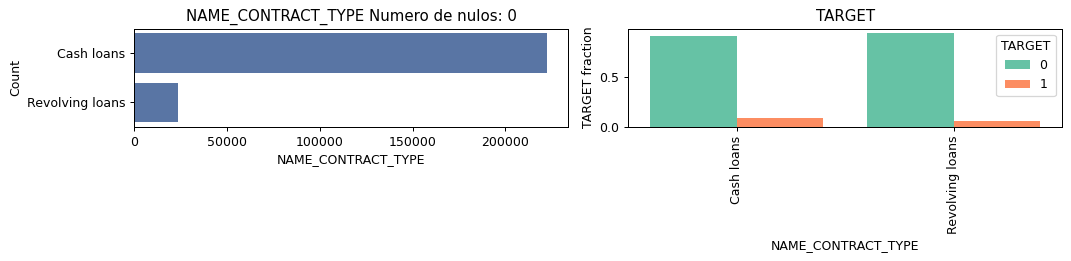

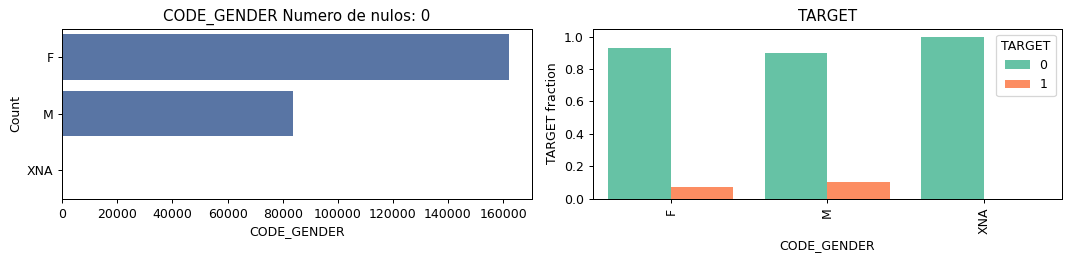

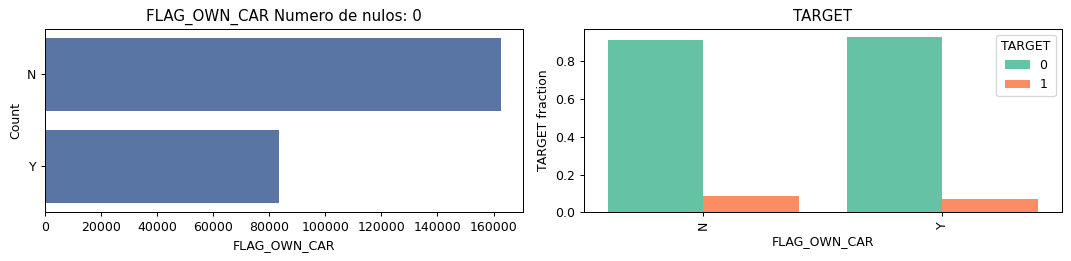

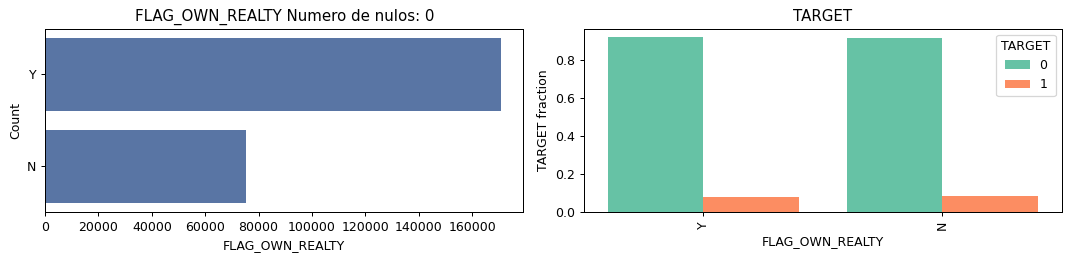

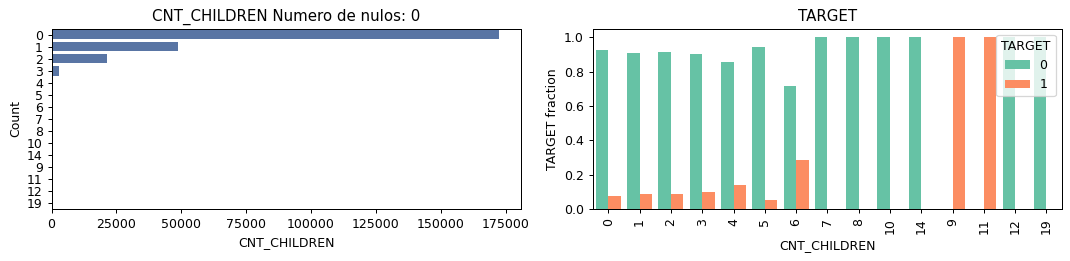

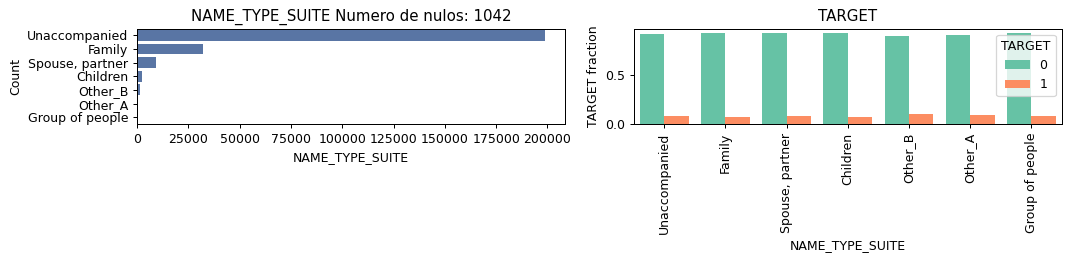

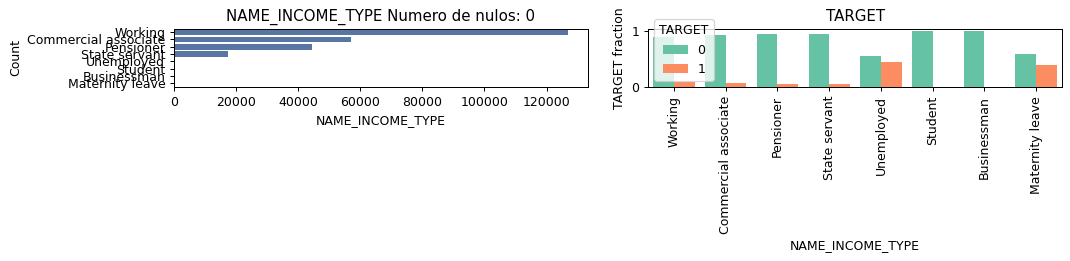

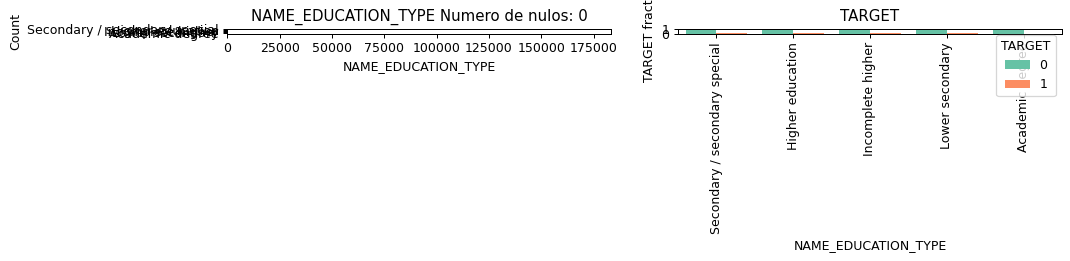

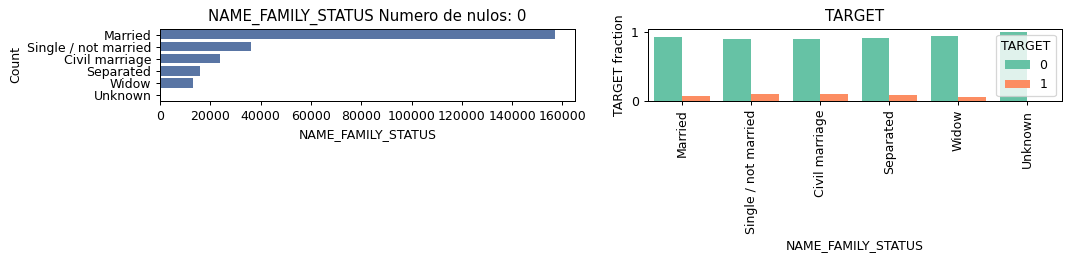

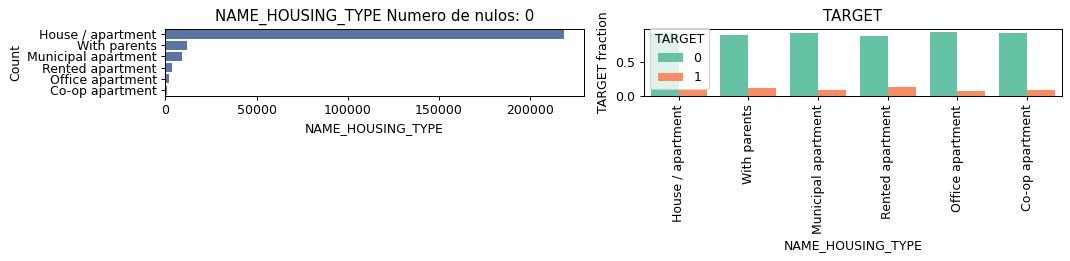

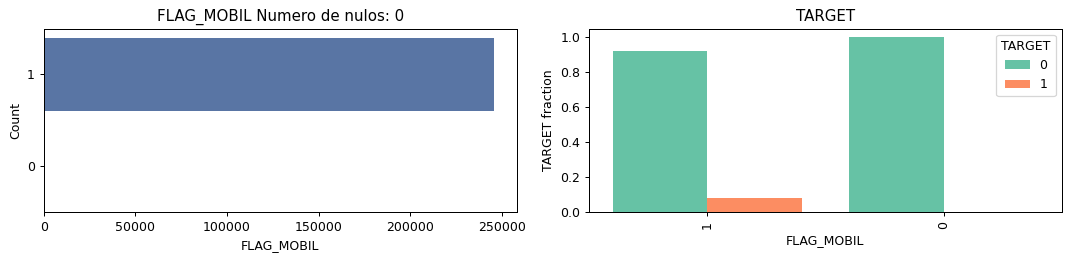

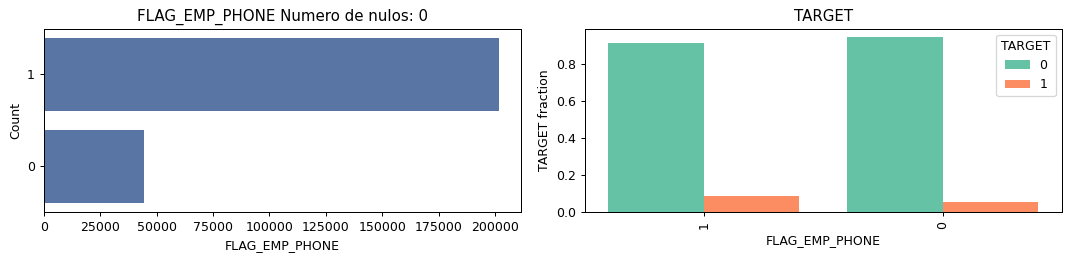

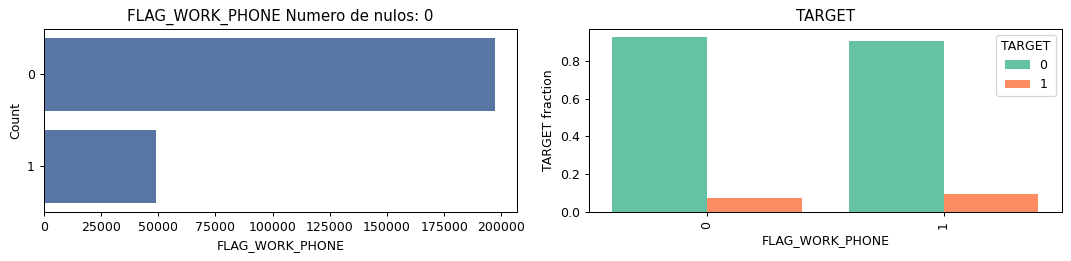

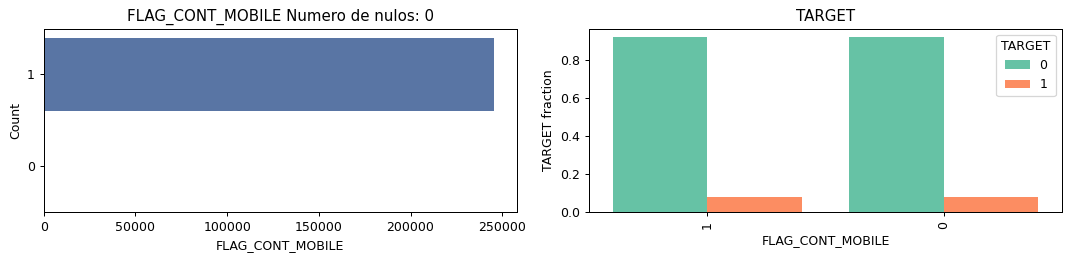

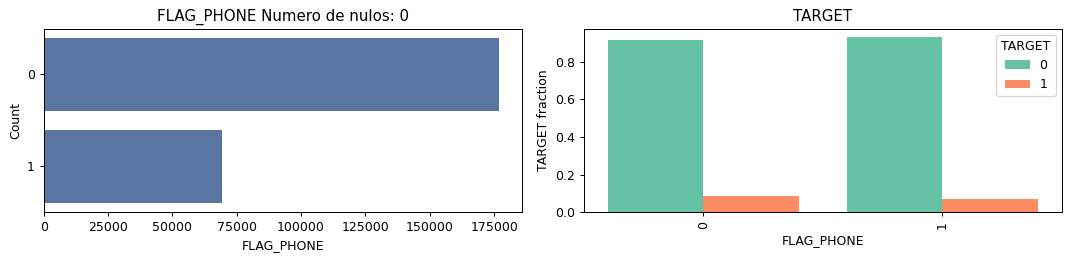

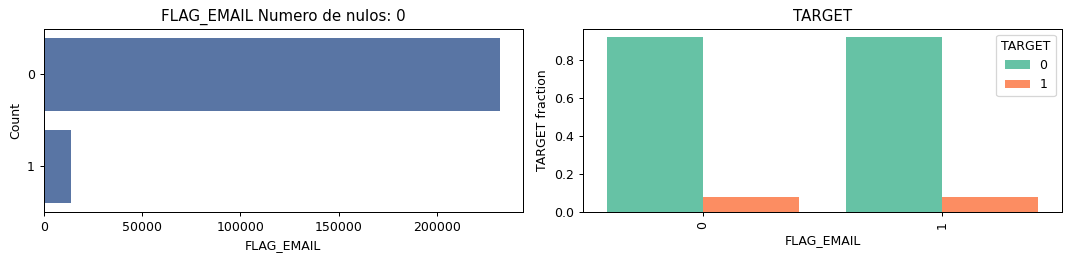

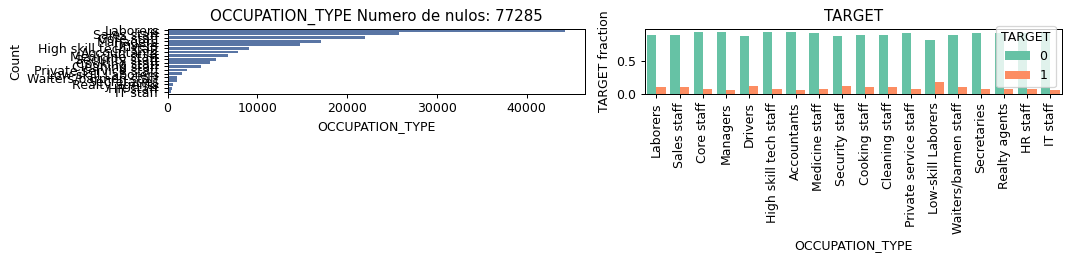

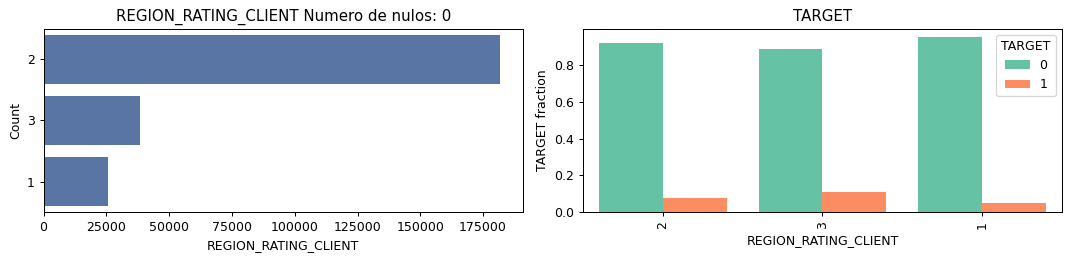

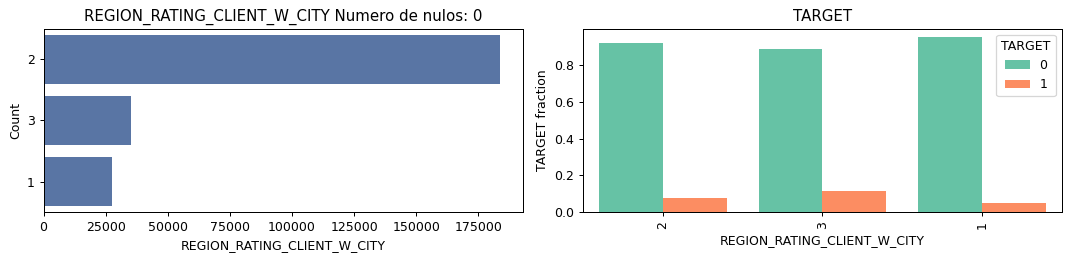

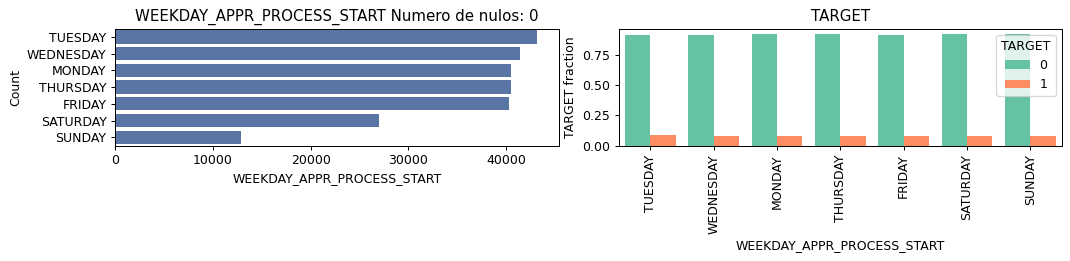

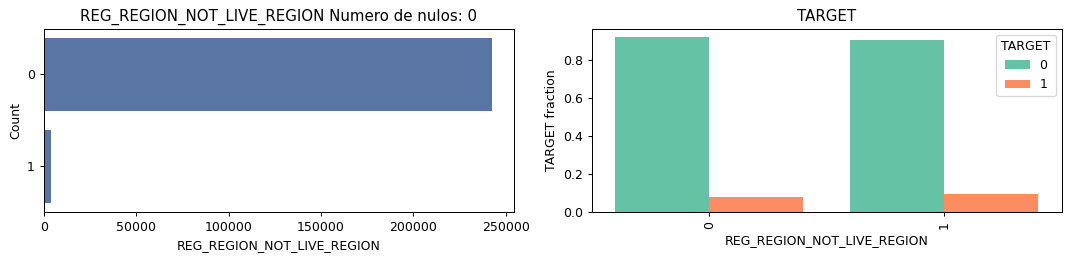

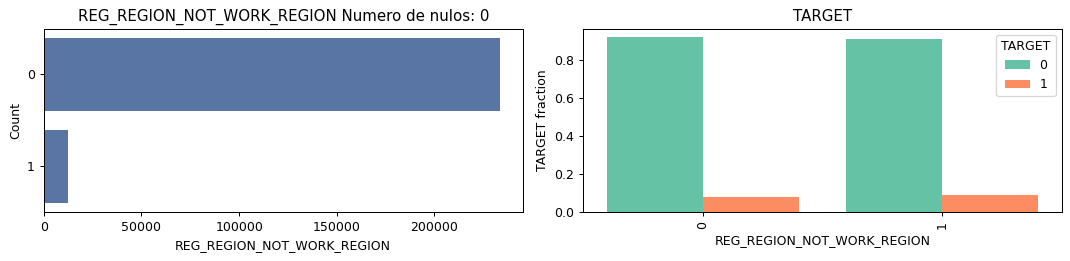

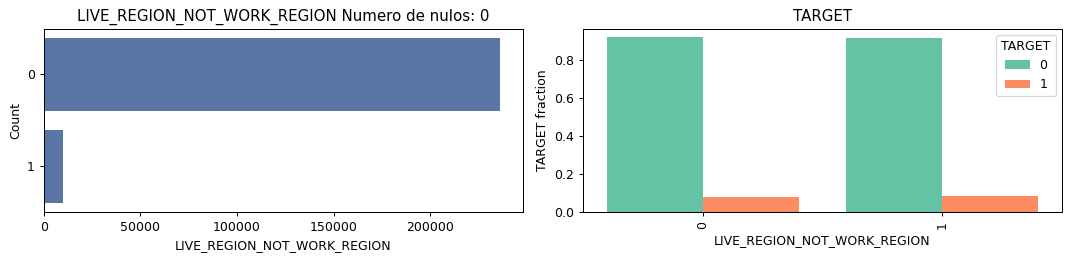

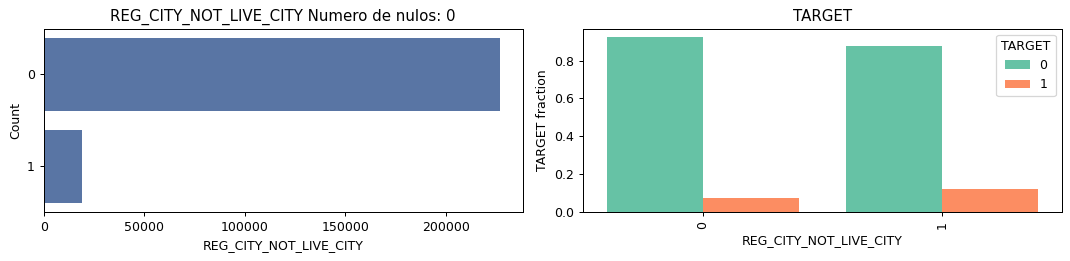

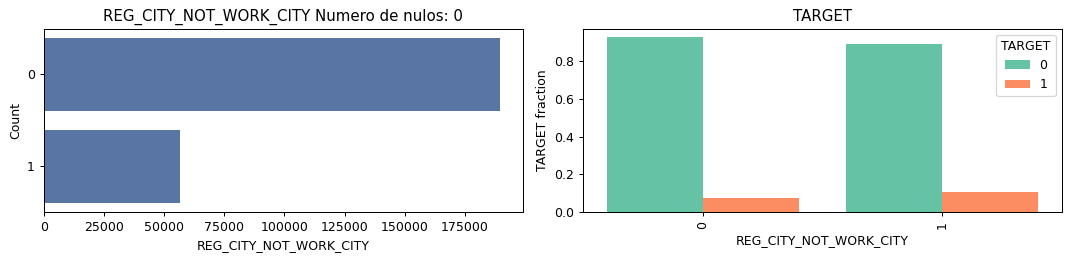

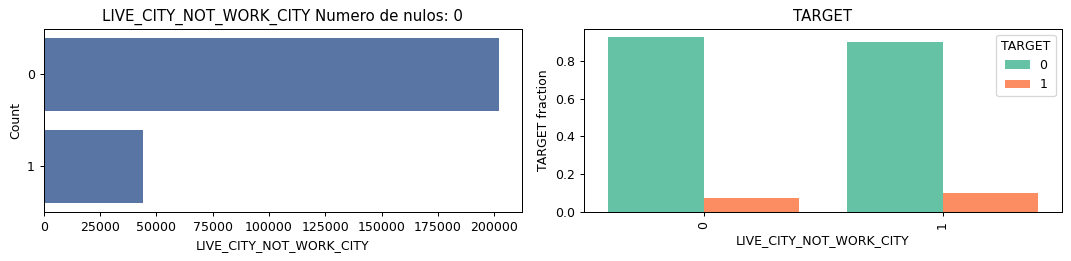

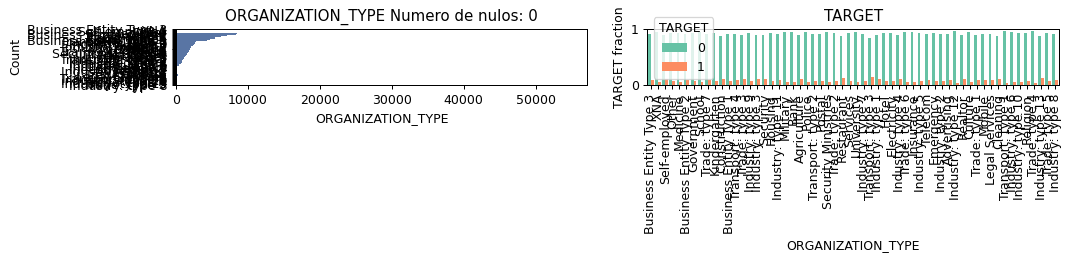

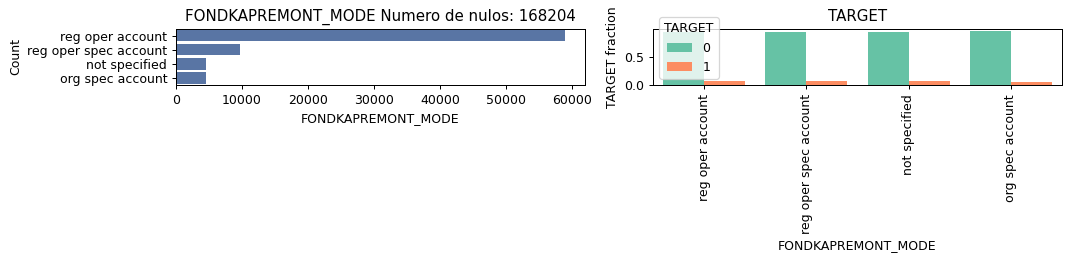

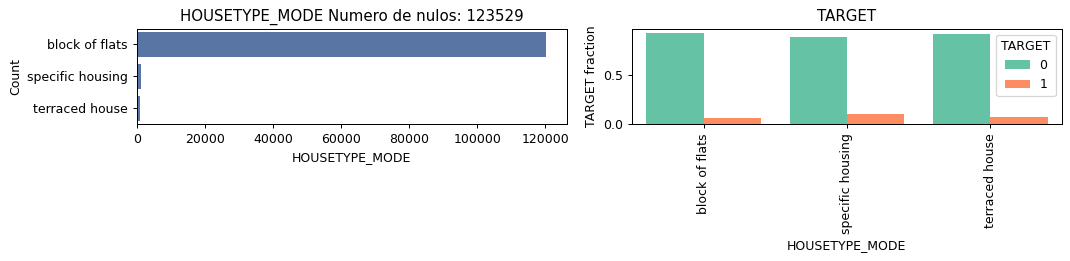

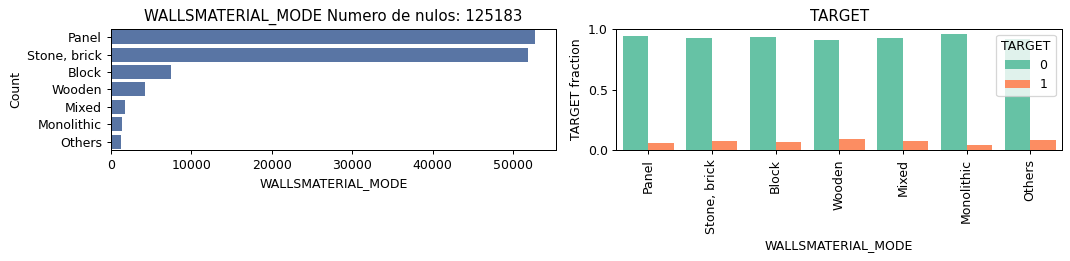

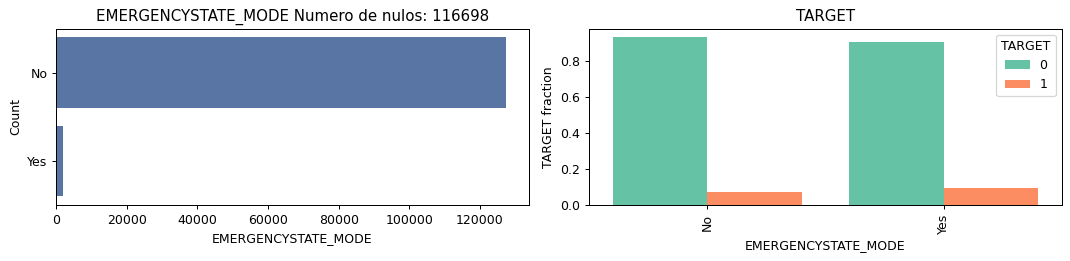

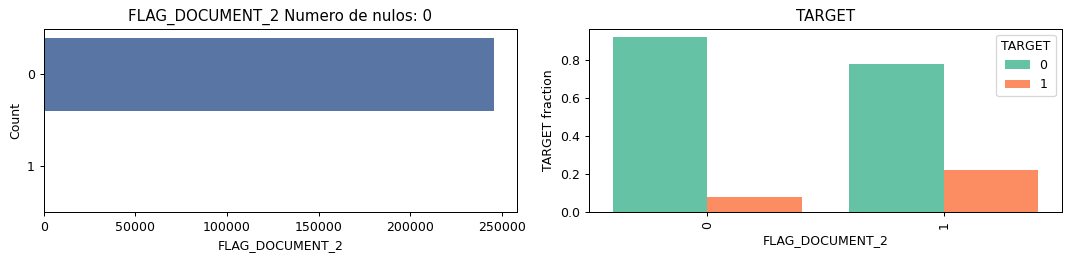

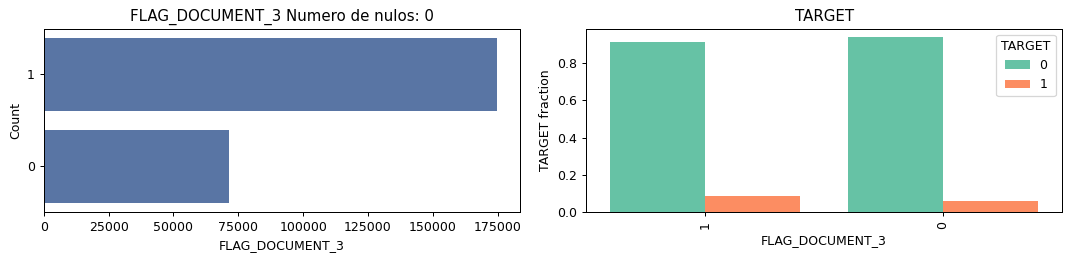

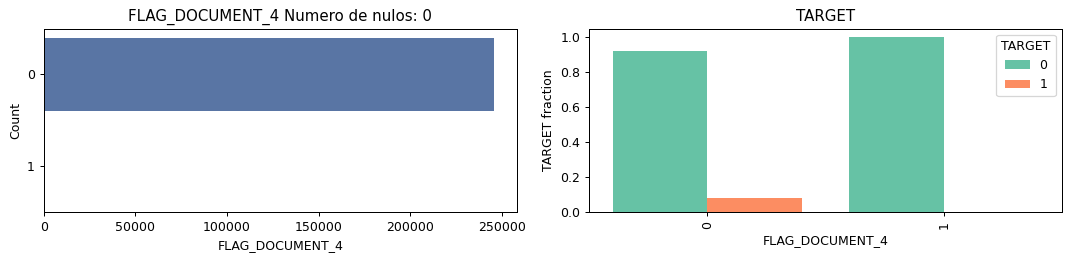

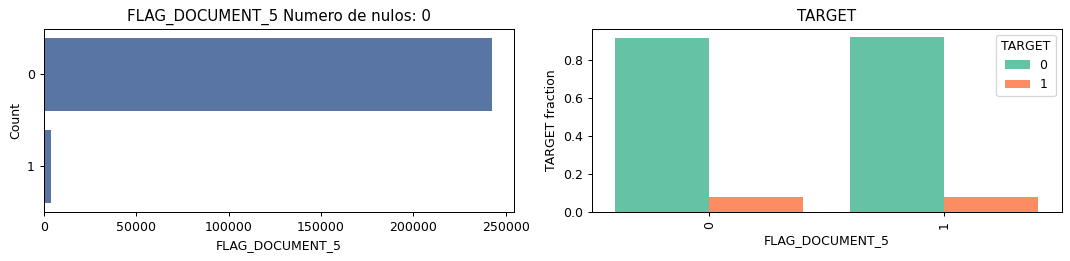

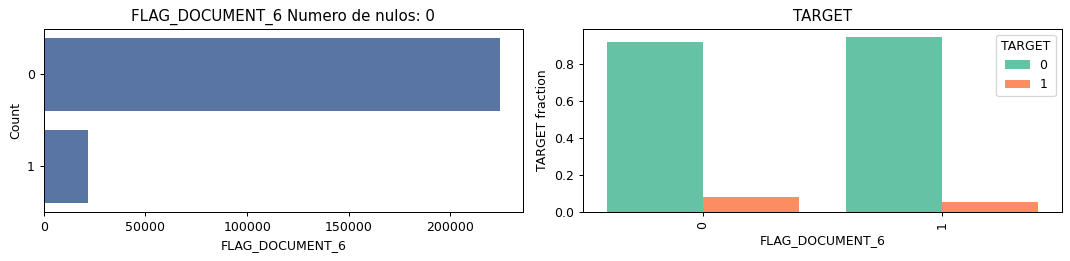

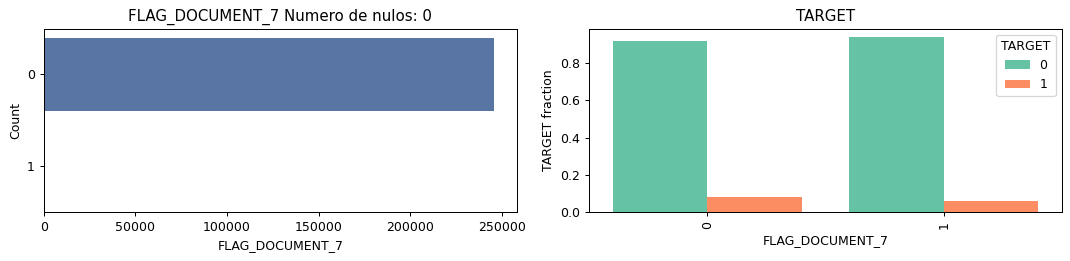

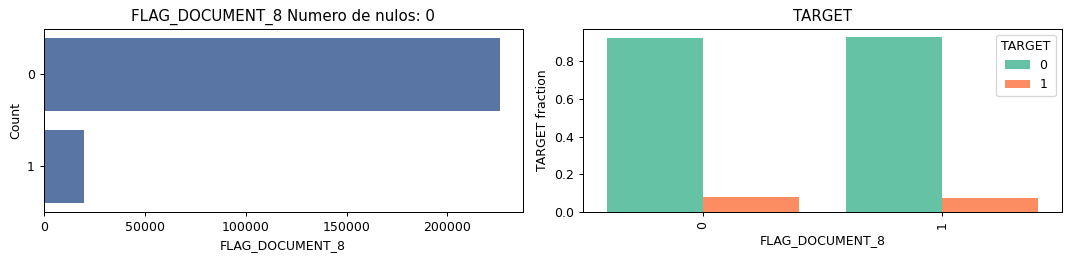

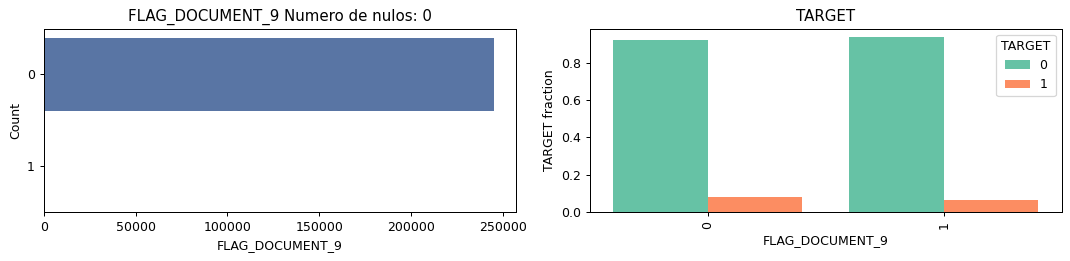

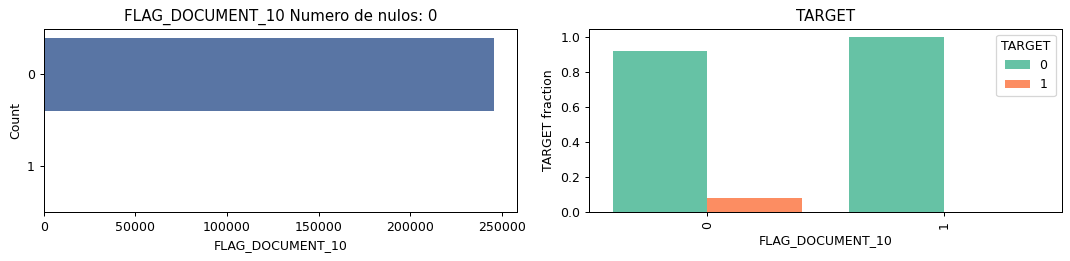

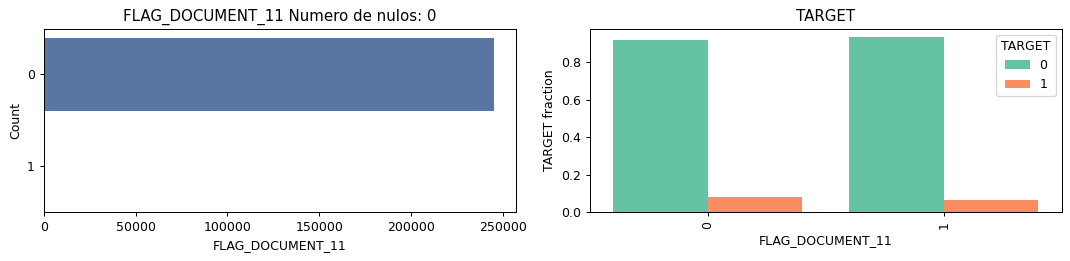

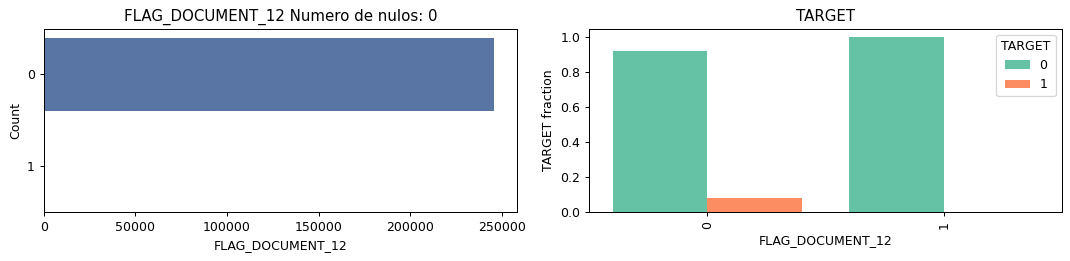

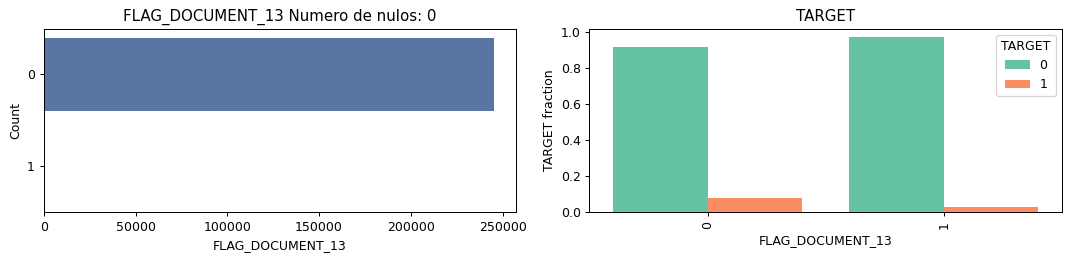

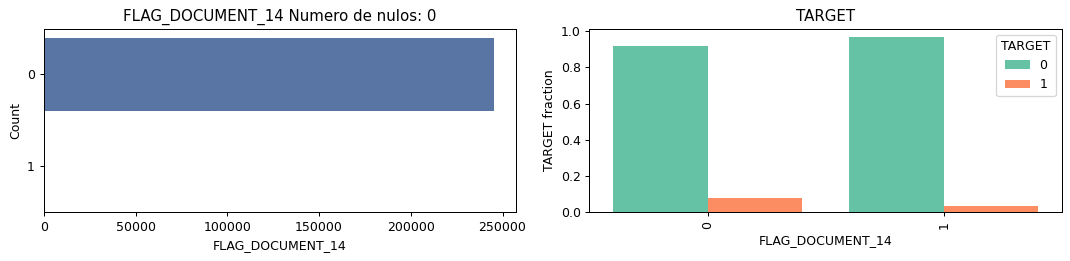

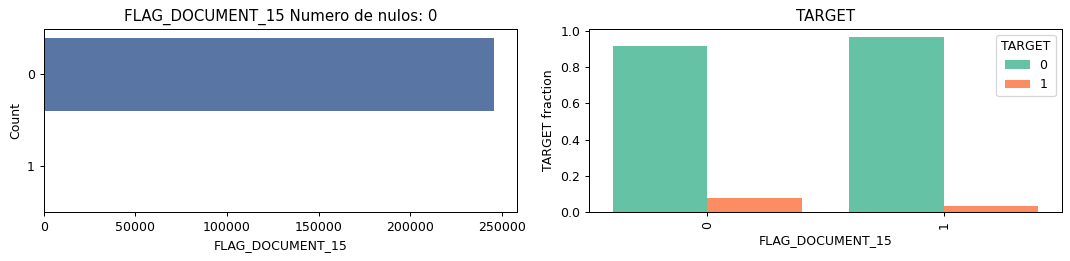

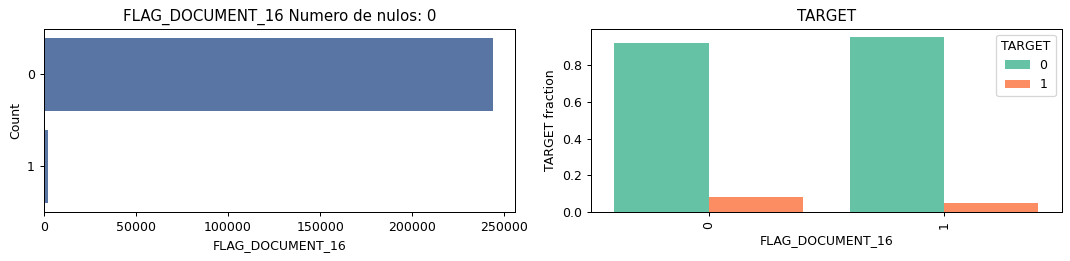

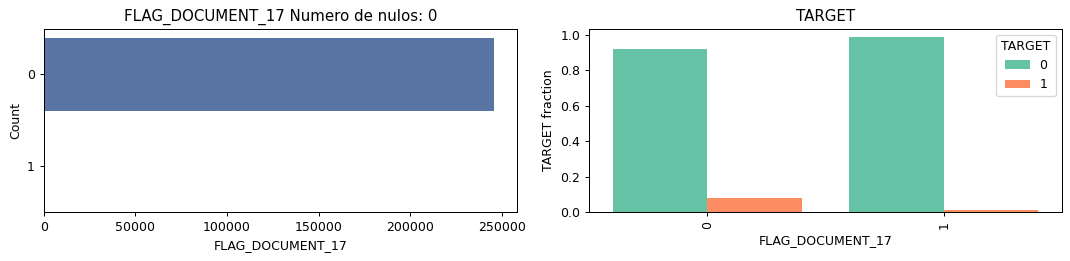

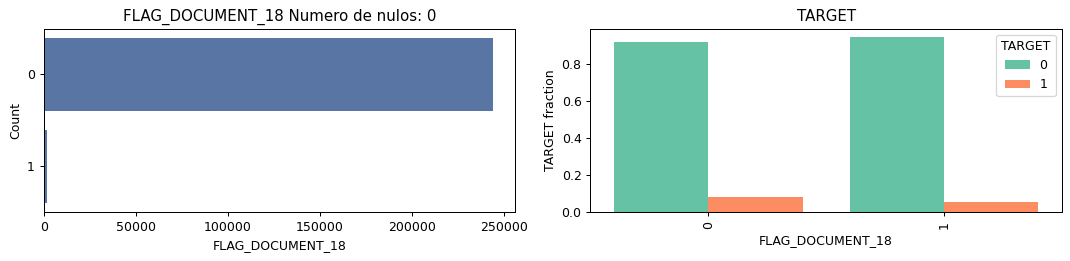

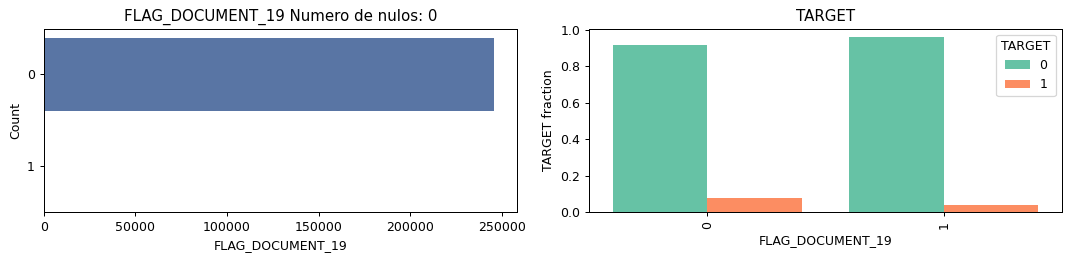

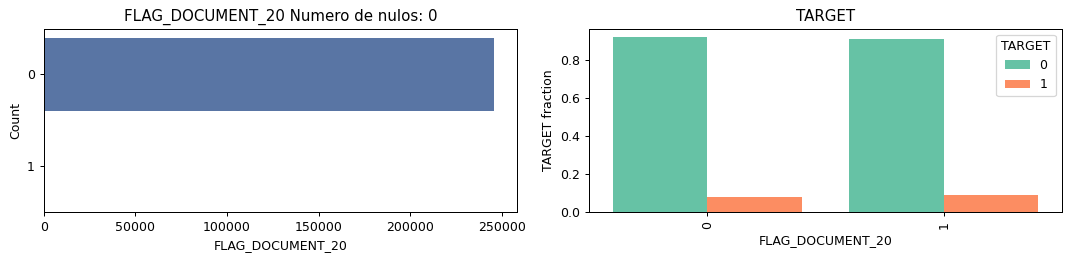

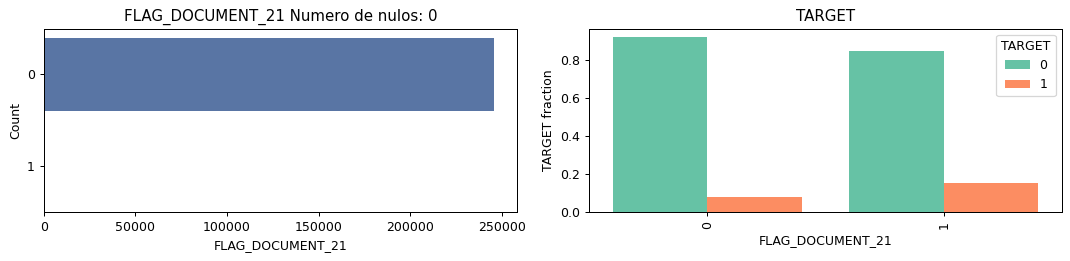

In [22]:
warnings.filterwarnings('ignore')
for i in list(pd_loan_train.columns):
    if (pd_loan_train[i].dtype!=float) & (i!='TARGET'):
        # print(i)
        plot_feature(pd_loan_train, col_name=i, isContinuous=False)

Para analizar las variables categóricas, inicio observando gráficos de barras, ya que son útiles para visualizar la distribución de las categorías y detectar posibles desbalances. Además, empleo gráficos de barras apiladas en función de la variable objetivo (`TARGET`) para analizar cómo se distribuyen las clases de `TARGET` entre las diferentes categorías. Si algunas categorías muestran una relación más marcada con la variable objetivo, esto puede indicar un mayor poder predictivo. También reviso la cantidad de valores nulos en estas variables, ya que su presencia puede afectar la calidad de los datos.

Es importante tener en cuenta que la variable objetivo está desbalanceada: el 91.93% de los casos corresponden a `TARGET` = 0 y solo el 8.07% a `TARGET`= 1. Este desequilibrio influye en la interpretación de los resultados y debe considerarse al realizar el análisis.

La primera variable analizada es el sexo del cliente. Aunque las diferencias son ligeras, se observa que los hombres, además de ser quienes solicitan menos préstamos, presentan una mayor probabilidad de enfrentar problemas con los pagos.

Una variable que destaca es el número de hijos de los clientes (`CNT_CHILDREN`). Los datos revelan que los clientes con más hijos tienden a experimentar mayores dificultades para cumplir con los pagos. Sin embargo, dado que la mayoría de los clientes tiene entre 0 y 1 hijo, las conclusiones sobre aquellos con un número elevado de hijos se basan en una muestra limitada, lo que reduce su representatividad.

Otra variable relevante es el tipo de ingresos de los clientes (`NAME_INCOME_TYPE`). Los resultados muestran que las personas sin empleo y aquellas en baja por maternidad enfrentan mayores dificultades para pagar. Por el contrario, los clientes que son empresarios no presentan problemas significativos con sus pagos.

En cuanto a la ocupación, los gráficos revelan que los clientes con trabajos de baja cualificación (Low-Skill Laborers) tienen más dificultades para cumplir con sus pagos. Este hallazgo resalta el impacto de la estabilidad laboral y los niveles de ingreso en el comportamiento de pago.

La región de residencia también influye significativamente en la probabilidad de dificultades de pago (`REGION_RATING_CLIENT`). En particular, los clientes de la región 3 son los que presentan mayores problemas para cumplir con sus pagos, seguidos por los de la región 2. En contraste, los clientes de la región 1 son quienes tienen menos dificultades.

Otro aspecto interesante es la variable relacionada con el documento 2 (`FLAG_DOCUMENT_2`). Los datos indican que las personas que han entregado este documento tienen una mayor proporción de dificultades de pago. Sin embargo, dado que la mayoría de los clientes no han proporcionado este documento, esta conclusión podría no ser representativa del comportamiento general.

Por último, en las variables categóricas booleanas no he identificado información particularmente útil. Esto se debe a que, al tener solo dos valores posibles, su variabilidad es limitada, lo que dificulta la detección de patrones claros o relaciones significativas con la variable objetivo. 

Es muy importante destacar que los datos de tipo entero que he definido como categóricos, incluidas las variables booleanas, no presentan ningún valor nulo.

# Tratamiento de las variables continuas

A continuación, se tratarán tres aspectos clave del análisis de los datos: los valores faltantes (missing), las correlaciones entre las variables continuas y los valores atípicos (outliers), con el objetivo de limpiar y entender mejor los datos antes de construir el modelo.

Primero, recuerdo cuales son las variables que he considerado como continuas: 

In [23]:
list_var_continuous

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONA

## Tratamiento de outliers

Los valores outliers se pueden sustituir por la media, mediana o utilizando valores extremos como la media ± 3 veces la desviación estándar. 

Es importante destacar que, antes de tratar los outliers, se debe analizar su relación con la variable objetivo y comprender su contexto, ya que podrían representar casos relevantes o errores de medición que influyan en la predicción del modelo.

In [24]:
def get_deviation_of_mean_perc(pd_loan, list_var_continuous, target, multiplier):
    '''
    ----------------------------------------------------------------------------------------------------------
    Función get_deviation_of_mean_perc:
    ----------------------------------------------------------------------------------------------------------
    - Descripción:
        Esta función calcula el porcentaje de valores que se encuentran fuera de un 
        intervalo de confianza, determinado por la media y una desviación estándar 
        multiplicada por un factor (multiplier), para cada variable continua en el 
        DataFrame. Luego, analiza la relación entre estos valores atípicos y la variable 
        objetivo (TARGET), y devuelve un resumen con los porcentajes de valores atípicos 
        y su distribución en relación con la variable objetivo.
        
    - Inputs: 
        - pd_loan (DataFrame): DataFrame que contiene los datos de entrada.
        - list_var_continuous (list): Lista con los nombres de las variables continuas 
          a analizar.
        - target (str): Nombre de la variable objetivo en el DataFrame.
        - multiplier (float): Factor multiplicador para calcular el intervalo de confianza
          (desviación estándar).
        
    - Return:
        - pd_final (DataFrame): DataFrame que contiene el porcentaje de valores atípicos 
          por cada variable continua, su distribución con respecto a la variable objetivo 
          (TARGET), y otros detalles relevantes.
    '''
    
    pd_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = pd_loan[i].mean()
        series_std = pd_loan[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_loan[i].size
        
        perc_goods = pd_loan[i][(pd_loan[i] >= left) & (pd_loan[i] <= right)].size/size_s
        perc_excess = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_loan[target][(pd_loan[i] < left) | (pd_loan[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]

            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final

In [25]:
get_deviation_of_mean_perc(pd_loan_train, list_var_continuous, target='TARGET', multiplier=3)

0.0       1.0                      variable  sum_outlier_values  \
0    0.000000  1.000000              AMT_INCOME_TOTAL                 206   
1    0.946602  0.053398              AMT_INCOME_TOTAL                 206   
2    0.000000  1.000000                    AMT_CREDIT                2637   
3    0.962078  0.037922                    AMT_CREDIT                2637   
4    0.000000  1.000000                   AMT_ANNUITY                2347   
5    0.962079  0.037921                   AMT_ANNUITY                2347   
6    0.000000  1.000000               AMT_GOODS_PRICE                3347   
7    0.964446  0.035554               AMT_GOODS_PRICE                3347   
8    0.000000  1.000000    REGION_POPULATION_RELATIVE                6707   
9    0.959296  0.040704    REGION_POPULATION_RELATIVE                6707   
10   0.000000  1.000000             DAYS_REGISTRATION                 612   
11   0.960784  0.039216             DAYS_REGISTRATION                 612   
12   0.000000  1.000000                   OWN_CAR_AGE                2692   
13   0.918276  0.081724                   OWN_CAR_AGE                2692   
14   0.000000  1.000000               CNT_FAM_MEMBERS                3234   
15   0.897341  0.102659               CNT_FAM_MEMBERS                3234   
16   0.000000  1.000000       HOUR_APPR_PROCESS_START                 486   
17   0.911523  0.088477       HOUR_APPR_PROCESS_START                 486   
18   0.000000  1.000000                APARTMENTS_AVG                2378   
19   0.951220  0.048780                APARTMENTS_AVG                2378   
20   0.000000  1.000000              BASEMENTAREA_AVG                1583   
21   0.949463  0.050537              BASEMENTAREA_AVG                1583   
22   0.000000  1.000000   YEARS_BEGINEXPLUATATION_AVG                 558   
23   0.908602  0.091398   YEARS_BEGINEXPLUATATION_AVG                 558   
24   0.000000  1.000000               YEARS_BUILD_AVG                 983   
25   0.923703  0.076297               YEARS_BUILD_AVG                 983   
26   0.000000  1.000000                COMMONAREA_AVG                1361   
27   0.950771  0.049229                COMMONAREA_AVG                1361   
28   0.000000  1.000000                 ELEVATORS_AVG                1927   
29   0.951738  0.048262                 ELEVATORS_AVG                1927   
30   0.000000  1.000000                 ENTRANCES_AVG                1756   
31   0.939066  0.060934                 ENTRANCES_AVG                1756   
32   0.000000  1.000000                 FLOORSMAX_AVG                2044   
33   0.953523  0.046477                 FLOORSMAX_AVG                2044   
34   0.000000  1.000000                 FLOORSMIN_AVG                 456   
35   0.958333  0.041667                 FLOORSMIN_AVG                 456   
36   0.000000  1.000000                  LANDAREA_AVG                1674   
37   0.940263  0.059737                  LANDAREA_AVG                1674   
38   0.000000  1.000000          LIVINGAPARTMENTS_AVG                1398   
39   0.949928  0.050072          LIVINGAPARTMENTS_AVG                1398   
40   0.000000  1.000000                LIVINGAREA_AVG                2537   
41   0.950729  0.049271                LIVINGAREA_AVG                2537   
42   0.000000  1.000000       NONLIVINGAPARTMENTS_AVG                 586   
43   0.933447  0.066553       NONLIVINGAPARTMENTS_AVG                 586   
44   0.000000  1.000000             NONLIVINGAREA_AVG                1923   
45   0.946958  0.053042             NONLIVINGAREA_AVG                1923   
46   0.000000  1.000000               APARTMENTS_MODE                2373   
47   0.949431  0.050569               APARTMENTS_MODE                2373   
48   0.000000  1.000000             BASEMENTAREA_MODE                1627   
49   0.947142  0.052858             BASEMENTAREA_MODE                1627   
50   0.000000  1.000000  YEARS_BEGINEXPLUATATION_MODE                 547   
51   0

Tras el análisis exploratorio, he decidido, como primera iteración, no sustituir los valores atípicos, ya que es importante evaluar su impacto en el modelo. Esta decisión también se debe a la gran cantidad de outliers observados, algunos de los cuales superan el 2% de los datos. Se puede observar que el porcentaje de la variable objetivo en cada variable cambiará al no considerar los outliers. Una vez construido el modelo, puedo realizar iteraciones utilizando diferentes métodos de tratamiento para evaluar si estos mejoran el rendimiento

## Correlaciones

En esta sección se analizarán las correlaciones entre las variables continuas utilizando la matriz de correlación de Pearson, que mide la fuerza y la dirección de una relación lineal entre dos variables numéricas. Los valores de Pearson oscilan entre -1 y 1, donde 1 indica una relación positiva perfecta, -1 una relación negativa perfecta, y 0 señala la ausencia de una relación lineal.



Es importante mencionar que se establece la autocorrelación en 0 para evitar distracción visual y centrar el análisis en relaciones entre distintas variables

In [26]:
def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    ''''
    ----------------------------------------------------------------------------------------------------------
    Función get_corr_matrix:
    ----------------------------------------------------------------------------------------------------------
    - Descripción:
        Esta función calcula y visualiza la matriz de correlación entre las variables 
        numéricas de un conjunto de datos. 

    - Inputs: 
        - dataset (DataFrame): Conjunto de datos con las variables numéricas a analizar.
        - metodo (str): Método de correlación a utilizar.
        - size_figure (list): Tamaño de la figura del gráfico.

    - Return:
        - None: Muestra un mapa de calor de la matriz de correlación.
    ----------------------------------------------------------------------------------------------------------
    '''
    
    # Comprobación de que se ha proporcionado el dataset
    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    
    # Calcular la matriz de correlación
    corr = dataset.corr(method=metodo) 
    
    # Establecer la autocorrelación a cero para evitar distracciones
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    
    f, ax = plt.subplots(figsize=size_figure)
    
    # Dibujar el mapa de calor con la correlación
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0

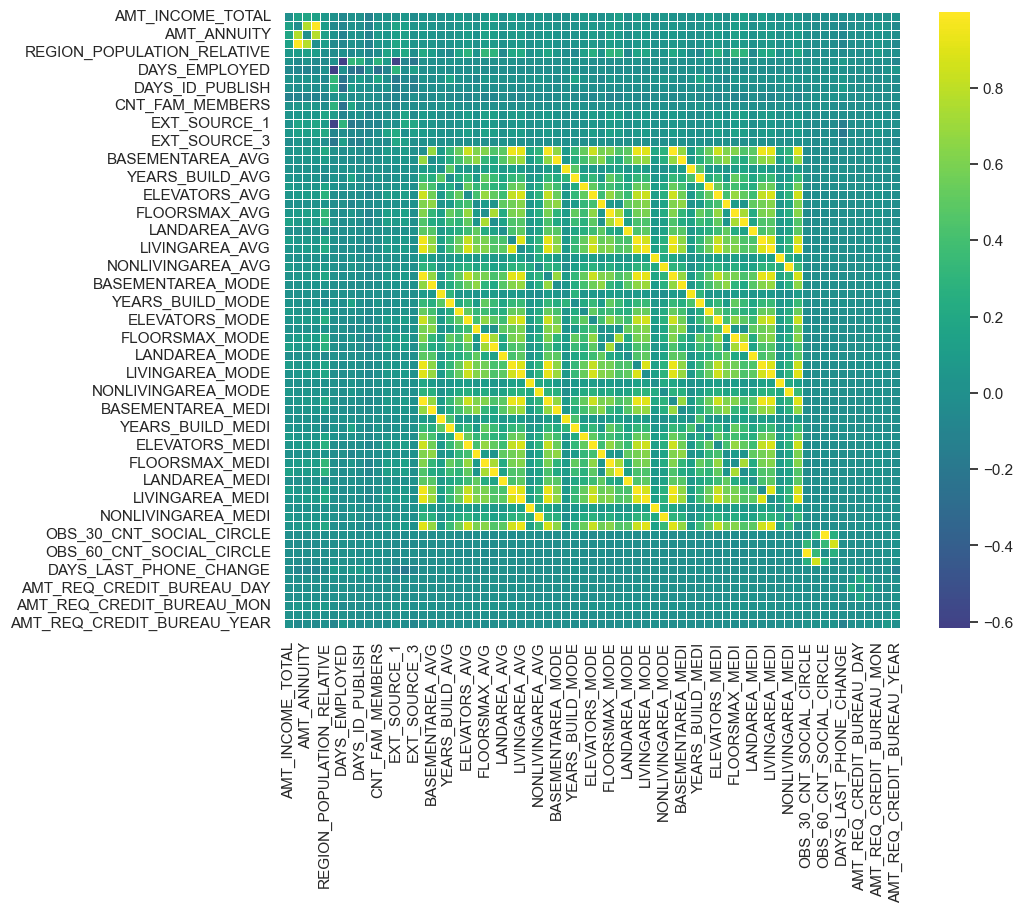

0

In [27]:
get_corr_matrix(dataset = pd_loan_train[list_var_continuous], 
                metodo='pearson', size_figure=[10,8])

En la matriz de correlación se observan varias correlaciones de Pearson cercanas o iguales a 1, lo que indica que algunas variables están perfectamente correlacionadas. Esto podría ser un indicio de la presencia de variables redundantes o derivadas de otras, lo que podría generar problemas de multicolinealidad en los modelos estadísticos.

Un patrón interesante que se observa es que existen correlaciones cercanas a 1 entre las variables que reflejan medidas como la media, mediana y moda de una misma característica. Este tipo de correlación sugiere que las variables podrían estar representando esencialmente la misma información. 

Más adelante, se revisarán estas variables y, si es necesario, se eliminarán aquellas que sean idénticas o altamente correlacionadas para evitar distorsionar los resultados del modelo.

En algoritmos basados en árboles, como XGBoost y Random Forest, la multicolinealidad no representa un problema significativo, ya que estos modelos no requieren que las variables sean independientes entre sí para hacer predicciones. De hecho, son capaces de manejar variables correlacionadas de forma eficiente sin que esto afecte su rendimiento.

Por otro lado, en modelos lineales como los GLM (Modelos Lineales Generalizados), la multicolinealidad sí puede comprometer la estabilidad e interpretación de los coeficientes. Esto ocurre porque la alta correlación entre las variables inflaría los errores estándar, lo que a su vez puede generar estimaciones inexactas. En este caso, será crucial eliminar o reducir la colinealidad antes de entrenar el modelo, para obtener resultados más fiables y estables.

In [28]:
corr = pd_loan_train[list_var_continuous].corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1)
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.6]

level_0                       level_1  correlation
3192              YEARS_BUILD_MEDI               YEARS_BUILD_AVG     0.998551
4198      OBS_60_CNT_SOCIAL_CIRCLE      OBS_30_CNT_SOCIAL_CIRCLE     0.998505
3542                FLOORSMIN_MEDI                 FLOORSMIN_AVG     0.997156
3472                FLOORSMAX_MEDI                 FLOORSMAX_AVG     0.996841
3402                ENTRANCES_MEDI                 ENTRANCES_AVG     0.996839
3332                ELEVATORS_MEDI                 ELEVATORS_AVG     0.995959
3752               LIVINGAREA_MEDI                LIVINGAREA_AVG     0.995537
3262               COMMONAREA_MEDI                COMMONAREA_AVG     0.995359
2982               APARTMENTS_MEDI                APARTMENTS_AVG     0.995067
3052             BASEMENTAREA_MEDI              BASEMENTAREA_AVG     0.994538
3682         LIVINGAPARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.994149
3122  YEARS_BEGINEXPLUATATION_MEDI   YEARS_BEGINEXPLUATATION_AVG     0.993896
3612                 LANDAREA_MEDI                  LANDAREA_AVG     0.991724
3822      NONLIVINGAPARTMENTS_MEDI       NONLIVINGAPARTMENTS_AVG     0.991668
3892            NONLIVINGAREA_MEDI             NONLIVINGAREA_AVG     0.990617
2226              YEARS_BUILD_MODE               YEARS_BUILD_AVG     0.989409
3206              YEARS_BUILD_MEDI              YEARS_BUILD_MODE     0.989353
3556                FLOORSMIN_MEDI                FLOORSMIN_MODE     0.988349
3486                FLOORSMAX_MEDI                FLOORSMAX_MODE     0.988335
208                AMT_GOODS_PRICE                    AMT_CREDIT     0.986964
2576                FLOORSMIN_MODE                 FLOORSMIN_AVG     0.985718
2506                FLOORSMAX_MODE                 FLOORSMAX_AVG     0.985543
3346                ELEVATORS_MEDI                ELEVATORS_MODE     0.982871
3626                 LANDAREA_MEDI                 LANDAREA_MODE     0.980586
3416                ENTRANCES_MEDI                ENTRANCES_MODE     0.980396
3836      NONLIVINGAPARTMENTS_MEDI      NONLIVINGAPARTMENTS_MODE     0.980105
3276               COMMONAREA_MEDI               COMMONAREA_MODE     0.978960
2366                ELEVATORS_MODE                 ELEVATORS_AVG     0.978751
3066             BASEMENTAREA_MEDI             BASEMENTAREA_MODE     0.978219
2436                ENTRANCES_MODE                 ENTRANCES_AVG     0.977458
2996               APARTMENTS_MEDI               APARTMENTS_MODE     0.976842
3906            NONLIVINGAREA_MEDI            NONLIVINGAREA_MODE     0.975700
2296               COMMONAREA_MODE                COMMONAREA_AVG     0.975659
3766               LIVINGAREA_MEDI               LIVINGAREA_MODE     0.975130
3696         LIVINGAPARTMENTS_MEDI         LIVINGAPARTMENTS_MODE     0.974923
2086             BASEMENTAREA_MODE              BASEMENTAREA_AVG     0.974046
2646                 LANDAREA_MODE                  LANDAREA_AVG     0.973596
2156  YEARS_BEGINEXPLUATATION_MODE   YEARS_BEGINEXPLUATATION_AVG     0.973276
2016               APARTMENTS_MODE                APARTMENTS_AVG     0.972894
2786               LIVINGAREA_MODE                LIVINGAREA_AVG     0.972433
2856      NONLIVINGAPARTMENTS_MODE       NONLIVINGAPARTMENTS_AVG     0.971974
2716         LIVINGAPARTMENTS_MODE          LIVINGAPARTMENTS_AVG     0.969810
3136  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BEGINEXPLUATATION_MODE     0.966521
2926            NONLIVINGAREA_MODE             NONLIVINGAREA_AVG     0.966084
1740          LIVINGAPARTMENTS_AVG                APARTMENTS_AVG     0.943506
3672         LIVINGAPARTMENTS_MEDI                APARTMENTS_AVG     0.942134
3700         LIVINGAPARTMENTS_MEDI               APARTMENTS_MEDI     0.941967
2720         LIVINGAPARTMENTS_MODE               APARTMENTS_MODE     0.938061
2992               APARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.935330
3006               APARTMENTS_MEDI         LIVINGAPARTMENTS_MODE     0.931642
2706         LIVINGAPARTMENTS_MODE               

En esta primera iteración, he optado por no eliminar las variables con altas correlaciones. Estas podrían ser candidatas a eliminación en pasos posteriores. Si en etapas futuras se utiliza un algoritmo que requiera la eliminación de la colinealidad, se procederá a eliminar las variables más correlacionadas para evitar posibles problemas en los resultados del modelo.

Por otro lado, comprobar la correlación de Spearman puede ser útil, ya que mide relaciones monótonas no lineales entre variables. Esto nos permitirá identificar patrones que podrían ser pasados por alto con Pearson.

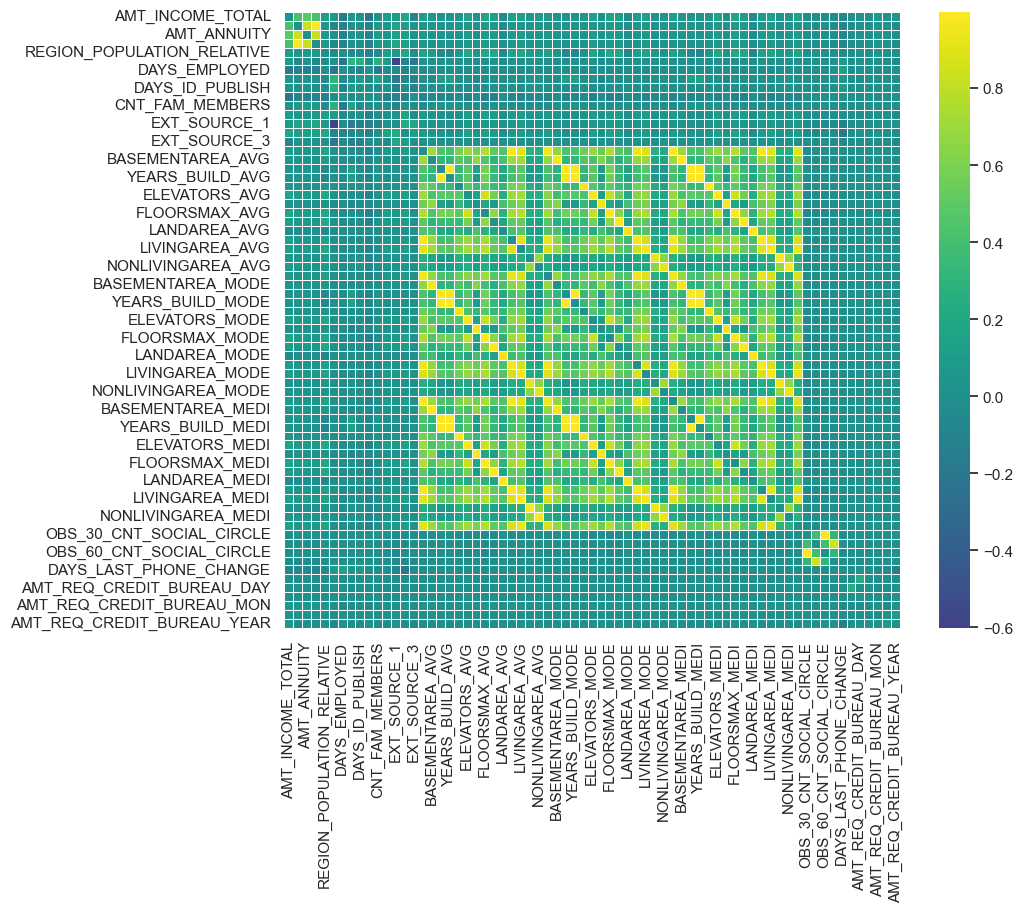

0

In [29]:
get_corr_matrix(dataset = pd_loan_train[list_var_continuous], 
                metodo='spearman', size_figure=[10,8])

In [31]:
corr = pd_loan_train[list_var_continuous].corr('spearman')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.6]

level_0                       level_1  correlation
3192              YEARS_BUILD_MEDI               YEARS_BUILD_AVG     0.998321
3122  YEARS_BEGINEXPLUATATION_MEDI   YEARS_BEGINEXPLUATATION_AVG     0.997420
4198      OBS_60_CNT_SOCIAL_CIRCLE      OBS_30_CNT_SOCIAL_CIRCLE     0.997349
3612                 LANDAREA_MEDI                  LANDAREA_AVG     0.996263
3682         LIVINGAPARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.996144
3542                FLOORSMIN_MEDI                 FLOORSMIN_AVG     0.996131
3262               COMMONAREA_MEDI                COMMONAREA_AVG     0.995543
3752               LIVINGAREA_MEDI                LIVINGAREA_AVG     0.995432
2982               APARTMENTS_MEDI                APARTMENTS_AVG     0.995085
3052             BASEMENTAREA_MEDI              BASEMENTAREA_AVG     0.994918
3472                FLOORSMAX_MEDI                 FLOORSMAX_AVG     0.994771
3402                ENTRANCES_MEDI                 ENTRANCES_AVG     0.993344
3332                ELEVATORS_MEDI                 ELEVATORS_AVG     0.990789
3206              YEARS_BUILD_MEDI              YEARS_BUILD_MODE     0.987810
2226              YEARS_BUILD_MODE               YEARS_BUILD_AVG     0.987541
1259               YEARS_BUILD_AVG   YEARS_BEGINEXPLUATATION_AVG     0.986782
3486                FLOORSMAX_MEDI                FLOORSMAX_MODE     0.986684
3556                FLOORSMIN_MEDI                FLOORSMIN_MODE     0.986501
3219              YEARS_BUILD_MEDI  YEARS_BEGINEXPLUATATION_MEDI     0.985613
3136  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BEGINEXPLUATATION_MODE     0.985395
3191              YEARS_BUILD_MEDI   YEARS_BEGINEXPLUATATION_AVG     0.985269
2156  YEARS_BEGINEXPLUATATION_MODE   YEARS_BEGINEXPLUATATION_AVG     0.984982
208                AMT_GOODS_PRICE                    AMT_CREDIT     0.984940
3123  YEARS_BEGINEXPLUATATION_MEDI               YEARS_BUILD_AVG     0.984107
2576                FLOORSMIN_MODE                 FLOORSMIN_AVG     0.982645
2506                FLOORSMAX_MODE                 FLOORSMAX_AVG     0.981667
3822      NONLIVINGAPARTMENTS_MEDI       NONLIVINGAPARTMENTS_AVG     0.981246
3892            NONLIVINGAREA_MEDI             NONLIVINGAREA_AVG     0.980796
2239              YEARS_BUILD_MODE  YEARS_BEGINEXPLUATATION_MODE     0.980131
3346                ELEVATORS_MEDI                ELEVATORS_MODE     0.977636
2225              YEARS_BUILD_MODE   YEARS_BEGINEXPLUATATION_AVG     0.974724
3137  YEARS_BEGINEXPLUATATION_MEDI              YEARS_BUILD_MODE     0.974333
1740          LIVINGAPARTMENTS_AVG                APARTMENTS_AVG     0.973459
3696         LIVINGAPARTMENTS_MEDI         LIVINGAPARTMENTS_MODE     0.973453
3276               COMMONAREA_MEDI               COMMONAREA_MODE     0.971115
3626                 LANDAREA_MEDI                 LANDAREA_MODE     0.971026
3700         LIVINGAPARTMENTS_MEDI               APARTMENTS_MEDI     0.970585
2996               APARTMENTS_MEDI               APARTMENTS_MODE     0.970032
3672         LIVINGAPARTMENTS_MEDI                APARTMENTS_AVG     0.969729
2716         LIVINGAPARTMENTS_MODE          LIVINGAPARTMENTS_AVG     0.969448
3766               LIVINGAREA_MEDI               LIVINGAREA_MODE     0.969297
3205              YEARS_BUILD_MEDI  YEARS_BEGINEXPLUATATION_MODE     0.969102
2157  YEARS_BEGINEXPLUATATION_MODE               YEARS_BUILD_AVG     0.968751
2366                ELEVATORS_MODE                 ELEVATORS_AVG     0.968452
2646                 LANDAREA_MODE                  LANDAREA_AVG     0.967450
2992               APARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.967347
2296               COMMONAREA_MODE                COMMONAREA_AVG     0.965393
3416                ENTRANCES_MEDI                ENTRANCES_MODE     0.965191
2016               APARTMENTS_MODE                APARTMENTS_AVG     0.964622
2786               LIVINGAREA_MODE                LIVINGAREA_AVG     0.964182
3066             BASEMENTAREA_MEDI             BA

La matriz de correlación de Spearman refleja relaciones monótonas, ya sean lineales o no lineales, y es menos sensible a los outliers. Por otro lado, la matriz de correlación de Pearson se centra en relaciones lineales. Ambas matrices proporcionan información valiosa sobre las dependencias entre variables.

Al comparar ambas matrices, se observa que las relaciones entre las variables son bastante similares tanto en Pearson como en Spearman, lo que sugiere que la mayoría de las relaciones son monótonas. Sin embargo, en la matriz de Spearman, se identifican algunas relaciones que no se habían observado con Pearson, lo que indica que existen patrones no lineales en los datos que no se capturan con la correlación lineal.

## Tratamiento de valores nulos

Antes de decidir cómo manejar los valores nulos, es fundamental analizar su distribución en relación con la variable objetivo. Específicamente, es útil determinar si los valores faltantes se concentran en una clase específica de la variable objetivo o si su distribución es uniforme.

In [32]:
list_var_continuous

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONA

In [33]:
def get_percent_null_values_target(pd_loan, list_var_continuous, target):
    '''
    ----------------------------------------------------------------------------------------------------------
    Función get_percent_null_values_target:
    ----------------------------------------------------------------------------------------------------------
    - Descripción:
        Esta función analiza la relación entre los valores nulos de variables continuas 
        y la variable objetivo. Identifica si los valores faltantes de cada variable se 
        distribuyen de forma uniforme respecto a las clases de la variable objetivo o si 
        están asociados de manera significativa a alguna de ellas.
        
    - Inputs: 
        - pd_loan (DataFrame): DataFrame que contiene los datos de entrada.
        - list_var_continuous (list): Lista de nombres de variables continuas a analizar.
        - target (str): Nombre de la variable objetivo.

    - Output:
        - pd_final (DataFrame): DataFrame que resumen del analisis de la relación entre 
          los valores nulos de variables continuas y la variable objetivo.
    ----------------------------------------------------------------------------------------------------------
    '''
    
    # DataFrame final donde se acumularán los resultados
    pd_final = pd.DataFrame()
    
    # Iterar sobre cada variable continua de la lista
    for i in list_var_continuous:
        if pd_loan[i].isnull().sum()>0:
            target_distribution = pd_loan[target][pd_loan[i].isnull()].value_counts(normalize=True)
            
            target_dict = target_distribution.to_dict()
            percent_0 = target_dict.get(0, 0)  
            percent_1 = target_dict.get(1, 0)  

            # Crear un DataFrame temporal con la estructura deseada
            temp_df = pd.DataFrame({
                '0': [percent_0],
                '1': [percent_1],
                'variable': [i],
                'sum_null_values': [pd_loan[i].isnull().sum()],
                'porcentaje_sum_null_values': [pd_loan[i].isnull().sum() / pd_loan.shape[0]]
            })
            pd_final = pd.concat([pd_final, temp_df], axis=0).reset_index(drop=True)
    
    # Si no se encuentran variables con valores nulos, mostrar un mensaje
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final

In [34]:
get_percent_null_values_target(pd_loan_train, list_var_continuous, target='TARGET')

0         1                      variable  sum_null_values  \
0   1.000000  0.000000                   AMT_ANNUITY               11   
1   0.919283  0.080717               AMT_GOODS_PRICE              223   
2   0.915013  0.084987                   OWN_CAR_AGE           162531   
3   1.000000  0.000000               CNT_FAM_MEMBERS                1   
4   0.914868  0.085132                  EXT_SOURCE_1           138726   
5   0.920304  0.079696                  EXT_SOURCE_2              527   
6   0.907571  0.092429                  EXT_SOURCE_3            48805   
7   0.908028  0.091972                APARTMENTS_AVG           124962   
8   0.910640  0.089360              BASEMENTAREA_AVG           144013   
9   0.907560  0.092440   YEARS_BEGINEXPLUATATION_AVG           120100   
10  0.912920  0.087080               YEARS_BUILD_AVG           163539   
11  0.914132  0.085868                COMMONAREA_AVG           171834   
12  0.908603  0.091397                 ELEVATORS_AVG           131208   
13  0.907825  0.092175                 ENTRANCES_AVG           124014   
14  0.907662  0.092338                 FLOORSMAX_AVG           122539   
15  0.913504  0.086496                 FLOORSMIN_AVG           166875   
16  0.911460  0.088540                  LANDAREA_AVG           146103   
17  0.913654  0.086346          LIVINGAPARTMENTS_AVG           168114   
18  0.908196  0.091804                LIVINGAREA_AVG           123568   
19  0.914007  0.085993       NONLIVINGAPARTMENTS_AVG           170734   
20  0.909175  0.090825             NONLIVINGAREA_AVG           135800   
21  0.908028  0.091972               APARTMENTS_MODE           124962   
22  0.910640  0.089360             BASEMENTAREA_MODE           144013   
23  0.907560  0.092440  YEARS_BEGINEXPLUATATION_MODE           120100   
24  0.912920  0.087080              YEARS_BUILD_MODE           163539   
25  0.914132  0.085868               COMMONAREA_MODE           171834   
26  0.908603  0.091397                ELEVATORS_MODE           131208   
27  0.907825  0.092175                ENTRANCES_MODE           124014   
28  0.907662  0.092338                FLOORSMAX_MODE           122539   
29  0.913504  0.086496                FLOORSMIN_MODE           166875   
30  0.911460  0.088540                 LANDAREA_MODE           146103   
31  0.913654  0.086346         LIVINGAPARTMENTS_MODE           168114   
32  0.908196  0.091804               LIVINGAREA_MODE           123568   
33  0.914007  0.085993      NONLIVINGAPARTMENTS_MODE           170734   
34  0.909175  0.090825            NONLIVINGAREA_MODE           135800   
35  0.908028  0.091972               APARTMENTS_MEDI           124962   
36  0.910640  0.089360             BASEMENTAREA_MEDI           144013   
37  0.907560  0.092440  YEARS_BEGINEXPLUATATION_MEDI           120100   
38  0.912920  0.087080              YEARS_BUILD_MEDI           163539   
39  0.914132  0.085868               COMMONAREA_MEDI           171834   
40  0.908603  0.091397                ELEVATORS_MEDI           131208   
41  0.907825  0.092175                ENTRANCES_MEDI           124014   
42  0.907662  0.092338                FLOORSMAX_MEDI           122539   
43  0.913504  0.086496                FLOORSMIN_MEDI           166875   
44  0.911460  0.088540                 LANDAREA_MEDI           146103   
45  0.913654  0.086346         LIVINGAPARTMENTS_MEDI           168114   
46  0.908196  0.091804               LIVINGAREA_MEDI           123568   
47  0.914007  0.085993      NONLIVINGAPARTMENTS_MEDI           170734   
48  0.909175  0.090825            NONLIVINGAREA_MEDI           135800   
49  0.907304  0.092696                TOTALAREA_MODE           118840   
50  0.965432  0.034568      OBS_30_CNT_SOCIAL_CIRCLE              810   
51  0.965432  0.034568      DEF_30_CNT_SOCIAL_CIRCLE              810   
52  0.965432  0.034568      OBS_60_CNT_SOCIAL_CIRCLE              810   
53  0.965432  0.034568      DEF_60_CNT_SOCIAL_CIRCLE              810

Como se comentó en el notebook anterior, el muestreo está desbalanceado, con la mayoría de los clientes sin dificultades para pagar el préstamo. Además, los valores faltantes se concentran principalmente en la clase 0 de la variable objetivo (clientes sin problemas de pago), siguiendo la misma tónica del desbalance presente en los datos.

Dado que al principio no cuento con suficiente contexto sobre las variables, se pueden emplear diferentes enfoques y comparar los resultados del modelo. Las opciones son las siguientes:

- Opción 0: Algunos algoritmos pueden manejar valores faltantes directamente, sin necesidad de imputarlos.

- Opción 1: Eliminar filas con valores nulos. No obstante, esta opción no es ideal en mi caso, ya que, como se ha observado, hay una cantidad significativa de filas con datos faltantes.

- Opción 2: Imputar los valores faltantes mediante técnicas estadísticas como la media, mediana, máximo, mínimo o incluso valores extremos.

- Opción 3: Rellenar los valores faltantes utilizando modelos de regresión, como KNN, regresión lineal o XGBoost. Sin embargo, este enfoque podría implicar un alto costo computacional y requiere cuidado para evitar el sobreajuste.


En este trabajo he optado por la opción 2 para imputar los valores faltantes utilizando la media o mediana. Esto es ideal para completar los datos sin recurrir a métodos costosos ni distorsionar su distribución. Descarto el uso de valores extremos, ya que las hay columnas que representan diferencias de tiempo, con valores tanto negativos como positivos. Además, Utilizar extremos podría introducir sesgos y afectar la coherencia del análisis.

Por lo tanto, imputar los valores faltantes con la media o la mediana permite mantener la coherencia y el equilibrio de las columnas, asegurando que los valores reemplazados sean representativos de la tendencia general de los datos sin introducir sesgos indebidos.

Es importante recordar que los valores faltantes en el conjunto de test se imputan utilizando la media calculada a partir del conjunto de train.

In [35]:
pd_loan_train[list_var_continuous] = pd_loan_train[list_var_continuous].apply(lambda x: x.fillna(x.median()))
pd_loan_test[list_var_continuous] = pd_loan_test[list_var_continuous].apply(lambda x: x.fillna(x.median()))

In [36]:
pd_loan_train[list_var_continuous]

AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
412054               90000.0    202500.0      10125.0         202500.0   
291454               81000.0    254700.0      25321.5         225000.0   
245085               67500.0    180000.0       9000.0         180000.0   
180128              157500.0    755190.0      36328.5         675000.0   
390833               72000.0    170640.0      13482.0         135000.0   
...                      ...         ...          ...              ...   
265043               90000.0   1078200.0      31522.5         900000.0   
102945              112500.0    239850.0      25447.5         225000.0   
392425              247500.0    450000.0      50904.0         450000.0   
282782              112500.0    502497.0      28188.0         454500.0   
292608              292500.0    447768.0      32710.5         405000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
412054                        0.003813    -16603.0        -3817.0   
291454                        0.006305    -21462.0       365243.0   
245085                        0.006296    -11454.0         -720.0   
180128                        0.018029    -20691.0       365243.0   
390833                        0.030755    -10901.0         -494.0   
...                                ...         ...            ...   
265043                        0.018634    -14717.0        -7906.0   
102945                        0.014464    -24853.0       365243.0   
392425                        0.028663    -12074.0         -332.0   
282782                        0.019101    -14665.0         -695.0   
292608                        0.005084    -16022.0         -458.0   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  CNT_FAM_MEMBERS  \
SK_ID_CURR                                                                     
412054                -6400.0           -144.0          9.0              2.0   
291454                 -888.0          -2351.0          9.0              2.0   
245085                 -533.0          -1927.0          2.0              5.0   
180128               -13572.0          -4254.0          9.0              2.0   
390833                -1869.0          -2314.0          9.0              2.0   
...                       ...              ...          ...              ...   
265043                -7566.0          -3682.0          9.0              2.0   
102945                 -269.0           -283.0          9.0              1.0   
392425                -6046.0          -1208.0          9.0              1.0   
282782                -2392.0          -3505.0          9.0              2.0   
292608                -3011.0          -5185.0          4.0              3.0   

            HOUR_APPR_PROCESS_START  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
SK_ID_CURR                                                                      
412054                         11.0      0.506409      0.480129      0.712155   
291454                          4.0      0.780222      0.234645      0.130947   
245085                         11.0      0.264202      0.362991      0.134265   
180128                         15.0      0.506409      0.180979      0.283712   
390833                          9.0      0.324140      0.685129      0.634706   
...                             ...           ...           ...           ...   
265043                         12.0      0.457477      0.661867      0.508287   
102945                         10.0      0.506409      0.456877      0.537070   
392425                         14.0      0.506409      0.308205      0.707699   
282782                          9.0      0.601350      0.600422      0.537070   
292608                         11.0      0.713731      0.647627      0.749022   

            APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGI

In [37]:
pd_loan_train.shape

(246008, 121)

Ahora verificamos que no hay variables con valores nulos, confirmando que el reemplazo se ha realizado con éxito.

In [38]:
get_percent_null_values_target(pd_loan_train, list_var_continuous, target='TARGET')

No existen variables con valores nulos


Empty DataFrame
Columns: []
Index: []

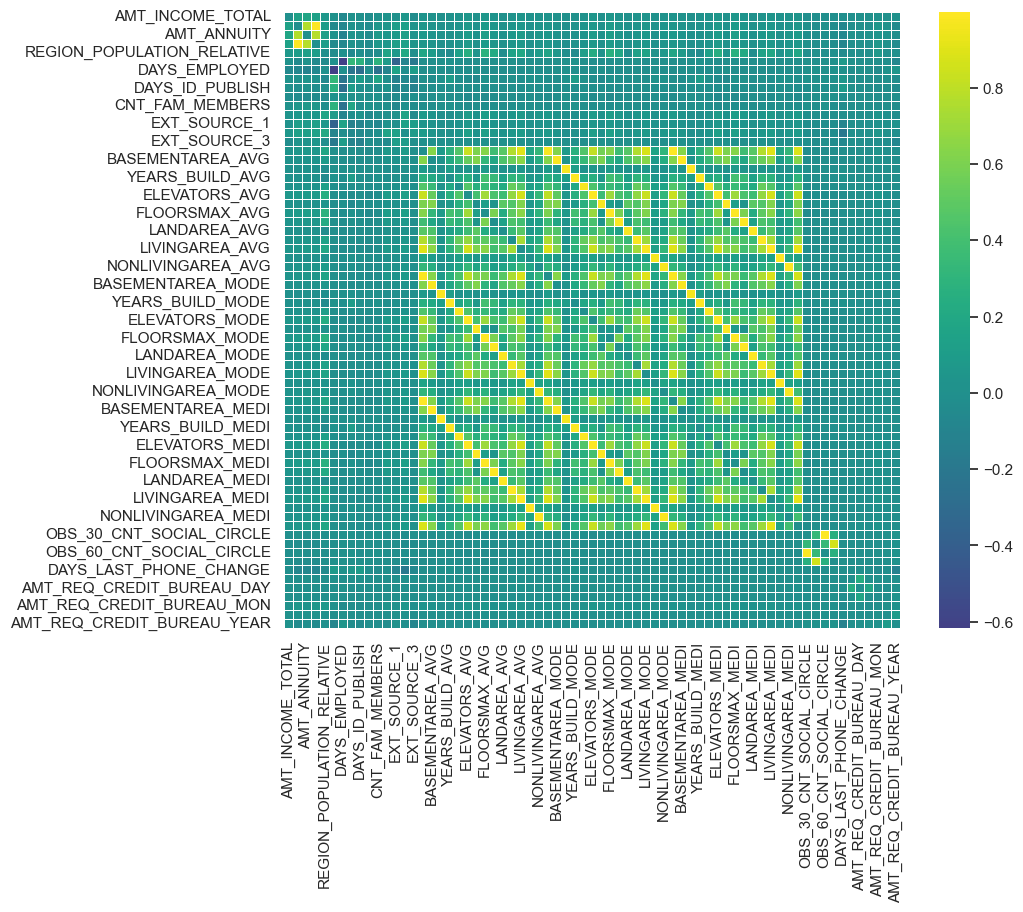

0

In [39]:
list_var_continuous = list(pd_loan_train.select_dtypes('float').columns)
get_corr_matrix(dataset = pd_loan_train[list_var_continuous], 
                metodo='pearson', size_figure=[10,8])

Dado que se han imputado los valores faltantes utilizando la mediana, al revisar la matriz de correlación de Pearson no se han observado diferencias significativas en comparación con los datos originales. Esto significa que el método de imputación ha funcionado bien y no ha alterado las relaciones entre las variables en el conjunto de datos.

## Tratamiento de las variables categoricas


El tratamiento de las variables categóricas incluye evaluar su relación y relevancia para el modelo. La medida V-Cramér evalúa la fuerza de la asociación entre dos variables categóricas, con valores cercanos a 1 indicando una fuerte relación. Este análisis ayuda a seleccionar variables relevantes y eliminar redundancias.

In [40]:
def cramers_v(confusion_matrix):
    ''' 
    ----------------------------------------------------------------------------------------------------------
    Función cramers_v:
    ----------------------------------------------------------------------------------------------------------
    - Descripción:
        Esta función calcula el estadístico V de Cramér para medir la asociación entre dos 
        variables categóricas. Utiliza la corrección de Bergsma y Wicher (2013) para ajustar
        el valor del chi-cuadrado y calcular una medida que indique la fuerza de la relación 
        entre las variables. El valor de Cramér's V oscila entre 0 (sin asociación) y 1 
        (asociación perfecta).
        
    - Inputs: 
        - confusion_matrix (DataFrame): Tabla de contingencia que contiene las frecuencias 
        absolutas de las categorías de las dos variables a analizar.
        
    - Output:
        - float: Valor de la V de Cramér 
    ----------------------------------------------------------------------------------------------------------    
    '''
    
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [41]:
confusion_matrix = pd.crosstab(pd_loan_train["TARGET"], pd_loan_train["TARGET"])
cramers_v(confusion_matrix.values)

0.9999726127135284

Analizamos la medida V de Cramér para cada una de las variables categóricas.

In [42]:
# Lista de variables categóricas excluyendo 'TARGET'
list_var_cat = [var for var in list_var_cat if var != "TARGET"]

# Iterar sobre las variables categóricas
for var in list_var_cat:
    print(f"Variable: {var}")
    
    # Matriz de confusión
    confusion_matrix = pd.crosstab(pd_loan_train["TARGET"], pd_loan_train[var])
    print("Confusion Matrix:")
    print(confusion_matrix)
    
    # Calcular Cramér's V
    cramer_v_value = cramers_v(confusion_matrix.values)
    print(f"Cramér's V: {cramer_v_value}")
    print("-" * 50)

Variable: NAME_CONTRACT_TYPE
Confusion Matrix:
NAME_CONTRACT_TYPE  Cash loans  Revolving loans
TARGET                                         
0                       204033            22115
1                        18575             1285
Cramér's V: 0.030631475041623155
--------------------------------------------------
Variable: CODE_GENDER
Confusion Matrix:
CODE_GENDER       F      M  XNA
TARGET                         
0            150907  75238    3
1             11309   8551    0
Cramér's V: 0.056193998989376125
--------------------------------------------------
Variable: FLAG_OWN_CAR
Confusion Matrix:
FLAG_OWN_CAR       N      Y
TARGET                     
0             148713  77435
1              13813   6047
Cramér's V: 0.021712059655003873
--------------------------------------------------
Variable: FLAG_OWN_REALTY
Confusion Matrix:
FLAG_OWN_REALTY      N       Y
TARGET                        
0                69000  157148
1                 6298   13562
Cramér's V: 0.006789

Confusion Matrix:
WEEKDAY_APPR_PROCESS_START  FRIDAY  MONDAY  SATURDAY  SUNDAY  THURSDAY  \
TARGET                                                                   
0                            37058   37437     24884   11842     37236   
1                             3294    3132      2121    1007      3268   

WEEKDAY_APPR_PROCESS_START  TUESDAY  WEDNESDAY  
TARGET                                          
0                             39571      38120  
1                              3671       3367  
Cramér's V: 0.007587215939167594
--------------------------------------------------
Variable: REG_REGION_NOT_LIVE_REGION
Confusion Matrix:
REG_REGION_NOT_LIVE_REGION       0     1
TARGET                                  
0                           222809  3339
1                            19514   346
Cramér's V: 0.00554276874440252
--------------------------------------------------
Variable: REG_REGION_NOT_WORK_REGION
Confusion Matrix:
REG_REGION_NOT_WORK_REGION       0      1
TARGET

Confusion Matrix:
FLAG_DOCUMENT_6       0      1
TARGET                        
0                205664  20484
1                 18662   1198
Cramér's V: 0.028977515723338728
--------------------------------------------------
Variable: FLAG_DOCUMENT_7
Confusion Matrix:
FLAG_DOCUMENT_7       0   1
TARGET                     
0                226102  46
1                 19857   3
Cramér's V: 0.0
--------------------------------------------------
Variable: FLAG_DOCUMENT_8
Confusion Matrix:
FLAG_DOCUMENT_8       0      1
TARGET                        
0                207623  18525
1                 18358   1502
Cramér's V: 0.005899766121420735
--------------------------------------------------
Variable: FLAG_DOCUMENT_9
Confusion Matrix:
FLAG_DOCUMENT_9       0    1
TARGET                      
0                225268  880
1                 19800   60
Cramér's V: 0.0031274860888368507
--------------------------------------------------
Variable: FLAG_DOCUMENT_10
Confusion Matrix:
FLAG_DOCU

Las variables analizadas muestran asociaciones débiles con la variable objetivo (`TARGET`), según los valores de Cramér's V, la mayoría menores a 0.1, indicando baja relación entre ellas y el incumplimiento de pagos. Esto sugiere que otras variables o enfoques podrían ser necesarios para mejorar el modelo predictivo.

Adicionalmente al coeficiente V de Cramer, he analizado en las variables categóricas el Weight of Evidence (WOE) y el Information Value (IV). El WOE mide la fuerza de la relación entre una variable categórica y la variable objetivo, transformando las categorías en valores continuos que reflejan el riesgo de un evento. Por su parte, el IV cuantifica la capacidad predictiva de una variable categórica, indicando qué tan bien una variable distingue entre las clases del objetivo.

In [43]:
def calculate_woe(df, target, feature):
    '''
    Función para calcular el WOE de una variable categórica en relación a un target binario.
    
    Parámetros:
    - df (DataFrame): DataFrame de pandas que contiene los datos.
    - target (str): Nombre de la variable objetivo.
    - feature (str): Nombre de la columna de la variable categórica.
    
    Retorna:
    - WOE (DataFrame): DataFrame con las categorías de la variable y su WOE correspondiente.
    '''
    
    # Crear tabla de contingencia entre feature y target
    cross_tab = pd.crosstab(df[feature], df[target])
    
    # Calcular el número total de eventos y no-eventos
    total_events = cross_tab.sum(axis=0)[1]  # Suma de eventos (1)
    total_non_events = cross_tab.sum(axis=0)[0]  # Suma de no-eventos (0)
    
    # Calcular las proporciones de eventos (1) y no-eventos (0) por categoría
    cross_tab['p_event'] = cross_tab[1] / total_events
    cross_tab['p_non_event'] = cross_tab[0] / total_non_events
    
    # Calcular WOE para cada categoría
    cross_tab['WOE'] = np.log(cross_tab['p_non_event'] / cross_tab['p_event'])
    
    # Filtrar solo las categorías y su WOE
    woe_values = cross_tab[['WOE']]
    
    return woe_values

In [44]:
# Iterar sobre las variables categóricas
for var in list_var_cat:
    print(f"Variable: {var}")
    # Calcular WOE
    woe_result = calculate_woe(pd_loan_train, 'TARGET', var)
    print(f"WOE: {woe_result}")
    print("-" * 50)

Variable: NAME_CONTRACT_TYPE
WOE: TARGET                   WOE
NAME_CONTRACT_TYPE          
Cash loans         -0.036017
Revolving loans     0.413015
--------------------------------------------------
Variable: CODE_GENDER
WOE: TARGET            WOE
CODE_GENDER          
F            0.158583
M           -0.257874
XNA               inf
--------------------------------------------------
Variable: FLAG_OWN_CAR
WOE: TARGET             WOE
FLAG_OWN_CAR          
N            -0.056074
Y             0.117395
--------------------------------------------------
Variable: FLAG_OWN_REALTY
WOE: TARGET                WOE
FLAG_OWN_REALTY          
N               -0.038608
Y                0.017434
--------------------------------------------------
Variable: CNT_CHILDREN
WOE: TARGET             WOE
CNT_CHILDREN          
0             0.051161
1            -0.115073
2            -0.075364
3            -0.224430
4            -0.650773
5             0.415330
6            -1.516191
7                  

WOE: TARGET                   WOE
WALLSMATERIAL_MODE          
Block               0.000238
Mixed              -0.084182
Monolithic          0.433797
Others             -0.213719
Panel               0.103376
Stone, brick       -0.064868
Wooden             -0.356804
--------------------------------------------------
Variable: EMERGENCYSTATE_MODE
WOE: TARGET                    WOE
EMERGENCYSTATE_MODE          
No                   0.005839
Yes                 -0.343323
--------------------------------------------------
Variable: FLAG_DOCUMENT_2
WOE: TARGET                WOE
FLAG_DOCUMENT_2          
0                0.000070
1               -1.179719
--------------------------------------------------
Variable: FLAG_DOCUMENT_3
WOE: TARGET                WOE
FLAG_DOCUMENT_3          
0                0.283598
1               -0.098690
--------------------------------------------------
Variable: FLAG_DOCUMENT_4
WOE: TARGET                WOE
FLAG_DOCUMENT_4          
0               -0.000

Teniendo en cuenta que la variable objetivo indica si el cliente ha tenido dificultades de pago (1) o no (0), los valores de WOE reflejan cómo las categorías de las variables afectan la probabilidad de que un cliente tenga dificultades de pago.

Por ejemplo, en la variable nivel educativo del cliente, el valor de WOE para título académico (1.34) indica que los clientes con este nivel educativo tienen una mayor probabilidad de no tener dificultades de pago. En cambio, los clientes con la secundaria incompleta tiene un valor WOE negativo (-0.32), lo que sugiere que los clientes con este nivel educativo tienen una mayor probabilidad de experimentar dificultades de pago.

En cuanto al tipo de contrato, los préstamos revolventes tienen un WOE positivo (0.43), lo que sugiere que los clientes con este tipo de préstamo son menos propensos a tener dificultades de pago. Por otro lado, los préstamos en efectivo tienen un WOE cercano a cero, indicando una relación débil con la probabilidad de impago.

Como mencionamos anteriormente, la variable tipo de ingreso es crucial. Los empresarios y estudiantes presentan un WOE infinito, lo que indica que tienen una relación muy fuerte con un bajo riesgo de impago. En cambio, los desempleados tienen un WOE negativo (-1.81), reflejando un alto riesgo de dificultades de pago.

Por último, en el tipo de ocupación, las ocupaciones de contadores y gerentes tienen WOE positivos, lo que indica un menor riesgo de impago, mientras que los trabajadores no calificados presentan un WOE negativo significativo (-0.82), lo que sugiere una mayor probabilidad de dificultades de pago.

Estos valores son fundamentales para identificar qué características de los clientes están asociadas con el riesgo de impago, lo que puede ser crucial en la futura construcción de modelos.

In [45]:
def calculate_iv(df, target, feature):
    '''
    Función para calcular el Information Value (IV) de una variable categórica en relación al target binario.
    
    Parámetros:
    - df (DataFrame): DataFrame de pandas que contiene los datos.
    - target (str): Nombre de la columna objetivo binaria.
    - feature (str): Nombre de la columna de la variable categórica.
    
    Retorna:
    - IV (float): El valor del Information Value.
    '''
    
    # Crear tabla de contingencia entre feature y target
    cross_tab = pd.crosstab(df[feature], df[target])
    
    # Calcular el número total de eventos y no-eventos
    total_events = cross_tab.sum(axis=0)[1]  # Suma de eventos (1)
    total_non_events = cross_tab.sum(axis=0)[0]  # Suma de no-eventos (0)
    
    # Calcular las proporciones de eventos (1) y no-eventos (0) por categoría
    cross_tab['p_event'] = cross_tab[1] / total_events
    cross_tab['p_non_event'] = cross_tab[0] / total_non_events
    
    # Calcular WOE para cada categoría
    cross_tab['WOE'] = np.log(cross_tab['p_non_event'] / cross_tab['p_event'])
    
    # Calcular IV sumando el producto de la diferencia de proporciones y WOE
    cross_tab['IV'] = (cross_tab['p_non_event'] - cross_tab['p_event']) * cross_tab['WOE']
    
    # Calcular el IV total
    iv_value = cross_tab['IV'].sum()
    
    return iv_value

In [46]:
# Iterar sobre las variables categóricas
for var in list_var_cat:
    print(f"Variable: {var}")
    # Calcular IV
    iv_value = calculate_iv(pd_loan_train, 'TARGET', var)
    print(f"IV: {iv_value}")
    print("-" * 50)

Variable: NAME_CONTRACT_TYPE
IV: 0.01485713973239661
--------------------------------------------------
Variable: CODE_GENDER
IV: inf
--------------------------------------------------
Variable: FLAG_OWN_CAR
IV: 0.006579164265910225
--------------------------------------------------
Variable: FLAG_OWN_REALTY
IV: 0.0006730581068082476
--------------------------------------------------
Variable: CNT_CHILDREN
IV: inf
--------------------------------------------------
Variable: NAME_TYPE_SUITE
IV: 0.0015187707080977805
--------------------------------------------------
Variable: NAME_INCOME_TYPE
IV: inf
--------------------------------------------------
Variable: NAME_EDUCATION_TYPE
IV: 0.05283797621606433
--------------------------------------------------
Variable: NAME_FAMILY_STATUS
IV: inf
--------------------------------------------------
Variable: NAME_HOUSING_TYPE
IV: 0.016146181390086785
--------------------------------------------------
Variable: FLAG_MOBIL
IV: inf
----------------

En resumen, las variables con un IV alto, como `OCCUPATION_TYPE` y `NAME_EDUCATION_TYPE`, tienen un mayor poder predictivo y son útiles para predecir las dificultades de pago. Por otro lado, las variables con un IV bajo o cercano a cero, como `FLAG_MOBIL` y `FLAG_CONT_MOBILE`, no aportan mucha información y podrían no ser relevantes para el modelo. En general, las variables con un IV más alto son las más importantes para el modelo, mientras que aquellas con IV bajo o infinito son candidatas a ser revisadas para evaluar su utilidad.

## Tratamiento de valores nulos

En las variables categóricas, los valores nulos suelen reemplazarse asignando una nueva categoría: "Sin valor". 

In [47]:
pd_loan_train[list_var_cat] = pd_loan_train[list_var_cat].astype("object").fillna("SIN VALOR").astype("category")
pd_loan_test[list_var_cat] = pd_loan_test[list_var_cat].astype("object").fillna("SIN VALOR").astype("category")

Es importante recordar que los datos de tipo entero definidos como categóricos, incluidas las variables booleanas, no presentan valores nulos. Sin embargo, si los tuvieran, deberían haberse tratado como parte del manejo de valores nulos numéricos. Para las variables booleanas, una opción sería imputar los nulos con -1, mientras que para las demás variables categóricas numéricas, sería necesario analizarlas con más detalle. Siguiendo el enfoque empleado hasta ahora, podríamos imputar los nulos con la mediana.

## Guardado de la tabla

Ahora, tras un segundo procesamiento y análisis de los datos, se guarda el DataFrame para conservar este nuevo estado intermedio y facilitar su uso en futuras etapas del análisis.

In [48]:
pd_loan_train.to_csv("../data/interim/train_pd_data_preprocessing_missing_outlier.csv")
pd_loan_test.to_csv("../data/interim/test_pd_data_preprocessing_missing_outlier.csv")

In [49]:
print(pd_loan_train.shape, pd_loan_test.shape)

(246008, 121) (61503, 121)
